#### CIND820 Capstone Project:      
# Implementing Machine Learning Price Prediction with the Ames Housing Dataset

### Setting Up Environment

Importing necessary libraries and modules

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import webbrowser
import timeit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV,train_test_split, cross_val_score
from scipy.stats import skew, norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
import graphviz
import xgboost as xgb
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, Activation
from keras.models import Sequential
from keras.regularizers import l1
from keras.wrappers.scikit_learn import KerasRegressor
from keras_visualizer import visualizer

C:\Users\david\anaconda3\envs\tf-gpu_T\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


There were some warning messages that repeated constantly later in the code so, though I'm aware of the issues, I ignore these warnings here.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Setting up display options for pandas

In [3]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 1. Basic Data Understanding & Data Cleaning

Loading and checking over dataset

In [4]:
amesH_data = pd.read_excel('data/AmesHousing.xls')

In [5]:
amesH_data.head(10)

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL     141.00000     31770   Pave   
1      2  526350040           20        RH      80.00000     11622   Pave   
2      3  526351010           20        RL      81.00000     14267   Pave   
3      4  526353030           20        RL      93.00000     11160   Pave   
4      5  527105010           60        RL      74.00000     13830   Pave   
5      6  527105030           60        RL      78.00000      9978   Pave   
6      7  527127150          120        RL      41.00000      4920   Pave   
7      8  527145080          120        RL      43.00000      5005   Pave   
8      9  527146030          120        RL      39.00000      5389   Pave   
9     10  527162130           60        RL      60.00000      7500   Pave   

  Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0   NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
1   NaN       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
2   NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
3   NaN       Reg          Lvl    AllPub     Corner        Gtl        NAmes   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
5   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
6   NaN       Reg          Lvl    AllPub     Inside        Gtl      StoneBr   
7   NaN       IR1          HLS    AllPub     Inside        Gtl      StoneBr   
8   NaN       IR1          Lvl    AllPub     Inside        Gtl      StoneBr   
9   NaN       Reg          Lvl    AllPub     Inside        Gtl      Gilbert   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
0        Norm        Norm      1Fam      1Story             6             5   
1       Feedr        Norm      1Fam      1Story             5             6   
2        Norm        Norm      1Fam      1Story             6             6   
3        Norm        Norm      1Fam      1Story             7             5   
4        Norm        Norm      1Fam      2Story             5             5   
5        Norm        Norm      1Fam      2Story             6             6   
6        Norm        Norm    TwnhsE      1Story             8             5   
7        Norm        Norm    TwnhsE      1Story             8             5   
8        Norm        Norm    TwnhsE      1Story             8             5   
9        Norm        Norm      1Fam      2Story             7             5   

   Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st Exterior 2nd  \
0        1960            1960        Hip   CompShg      BrkFace      Plywood   
1        1961            1961      Gable   CompShg      VinylSd      VinylSd   
2        1958            1958        Hip   CompShg      Wd Sdng      Wd Sdng   
3        1968            1968        Hip   CompShg      BrkFace      BrkFace   
4        1997            1998      Gable   CompShg      VinylSd      VinylSd   
5        1998            1998      Gable   CompShg      VinylSd      VinylSd   
6        2001            2001      Gable   CompShg      CemntBd      CmentBd   
7        1992            1992      Gable   CompShg      HdBoard      HdBoard   
8        1995            1996      Gable   CompShg      CemntBd      CmentBd   
9        1999            1999      Gable   CompShg      VinylSd      VinylSd   

  Mas Vnr Type  Mas Vnr Area Exter Qual Exter Cond Foundation Bsmt Qual  \
0        Stone     112.00000         TA         TA     CBlock        TA   
1         None       0.00000         TA         TA     CBlock        TA   
2      BrkFace     108.00000         TA         TA     CBlock        TA   
3         None       0.00000         Gd         TA     CBlock        TA   
4         None       0.00000         TA         TA      PConc        Gd   
5      BrkFace      20.00000         TA         TA      PConc        TA   
6        

In [6]:
amesH_data.shape

(2930, 82)

In [7]:
amesH_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

Checking for Duplicate Values

In [8]:
amesH_data[amesH_data.duplicated(keep='last')]


Empty DataFrame
Columns: [Order, PID, MS SubClass, MS Zoning, Lot Frontage, Lot Area, Street, Alley, Lot Shape, Land Contour, Utilities, Lot Config, Land Slope, Neighborhood, Condition 1, Condition 2, Bldg Type, House Style, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Roof Style, Roof Matl, Exterior 1st, Exterior 2nd, Mas Vnr Type, Mas Vnr Area, Exter Qual, Exter Cond, Foundation, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin SF 1, BsmtFin Type 2, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Heating, Heating QC, Central Air, Electrical, 1st Flr SF, 2nd Flr SF, Low Qual Fin SF, Gr Liv Area, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces, Fireplace Qu, Garage Type, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Pool QC, Fence, Misc Feature, Misc Val, Mo Sold, Yr Sold, Sale Type, Sale Condition, SalePrice]
Index: []

Setting the target variable

In [9]:
target = amesH_data['SalePrice']

Basic Summary Statistics for Target

In [10]:
T_Summary = amesH_data['SalePrice'].describe()
T_mode = amesH_data['SalePrice'].mode()
T_Summary.loc['mode'] = T_mode.iloc[0]
T_Summary.loc['skew']=amesH_data['SalePrice'].skew()
T_Summary.loc['kurt'] = amesH_data['SalePrice'].kurt()
T_Summary.loc['Na'] = amesH_data['SalePrice'].isna().sum()
T_Summary.loc['dtype']= amesH_data['SalePrice'].dtypes
T_Summary

count     2930.00000
mean    180796.06007
std      79886.69236
min      12789.00000
25%     129500.00000
50%     160000.00000
75%     213500.00000
max     755000.00000
mode    135000.00000
skew         1.74350
kurt         5.11890
Na           0.00000
dtype          int64
Name: SalePrice, dtype: object

Creating indexes for discrete, continuous, ordinal, and nominal features while displaying the number of each type of feature.

In [11]:
discFeat = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces','Garage Yr Blt', 'Garage Cars', 'Yr Sold']
len(discFeat)

13

In [12]:
contFeat = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']
len(contFeat)

19

In [13]:
ordF = ['Street', 'Alley','Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence']
len(ordF)

25

In [14]:
nomF = ['MS SubClass', 'MS Zoning', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Mo Sold', 'Sale Type', 'Sale Condition']
len(nomF)

22

## 1. Basic Summary Statistics for Discrete Features

In [15]:
discFeat_Summary = amesH_data[discFeat].describe()
d_mode = amesH_data[discFeat].mode()
discFeat_Summary.loc['mode'] = d_mode.iloc[0]
discFeat_Summary.loc['skew']=amesH_data[discFeat].skew()
discFeat_Summary.loc['kurt'] =amesH_data[discFeat].kurt()
discFeat_Summary.loc['Na'] = amesH_data[discFeat].isna().sum()
discFeat_Summary.loc['dtype'] = amesH_data[discFeat].dtypes
discFeat_Summary

Year Built Year Remod/Add Bsmt Full Bath Bsmt Half Bath  Full Bath  \
count 2930.00000     2930.00000     2928.00000     2928.00000 2930.00000   
mean  1971.35631     1984.26655        0.43135        0.06113    1.56655   
std     30.24536       20.86029        0.52482        0.24525    0.55294   
min   1872.00000     1950.00000        0.00000        0.00000    0.00000   
25%   1954.00000     1965.00000        0.00000        0.00000    1.00000   
50%   1973.00000     1993.00000        0.00000        0.00000    2.00000   
75%   2001.00000     2004.00000        1.00000        0.00000    2.00000   
max   2010.00000     2010.00000        3.00000        2.00000    4.00000   
mode  2005.00000     1950.00000        0.00000        0.00000    2.00000   
skew    -0.60446       -0.45186        0.61664        3.94080    0.17195   
kurt    -0.50172       -1.34152       -0.74799       14.92174   -0.54144   
Na       0.00000        0.00000        2.00000        2.00000    0.00000   
dtype      int64          int64        float64        float64      int64   

       Half Bath Bedroom AbvGr Kitchen AbvGr TotRms AbvGrd Fireplaces  \
count 2930.00000    2930.00000    2930.00000    2930.00000 2930.00000   
mean     0.37952       2.85427       1.04437       6.44300    0.59932   
std      0.50263       0.82773       0.21408       1.57296    0.64792   
min      0.00000       0.00000       0.00000       2.00000    0.00000   
25%      0.00000       2.00000       1.00000       5.00000    0.00000   
50%      0.00000       3.00000       1.00000       6.00000    1.00000   
75%      1.00000       3.00000       1.00000       7.00000    1.00000   
max      2.00000       8.00000       3.00000      15.00000    4.00000   
mode     0.00000       3.00000       1.00000       6.00000    0.00000   
skew     0.69771       0.30569       4.31382       0.75354    0.73922   
kurt    -1.03034       1.89142      19.86974       1.15459    0.10151   
Na       0.00000       0.00000       0.00000       0.00000    0.00000   
dtype      int64         int64         int64         int64      int64   

      Garage Yr Blt Garage Cars    Yr Sold  
count    2771.00000  2929.00000 2930.00000  
mean     1978.13244     1.76681 2007.79044  
std        25.52841     0.76057    1.31661  
min      1895.00000     0.00000 2006.00000  
25%      1960.00000     1.00000 2007.00000  
50%      1979.00000     2.00000 2008.00000  
75%      2002.00000     2.00000 2009.00000  
max      2207.00000     5.00000 2010.00000  
mode     2005.00000     2.00000 2007.00000  
skew       -0.38467    -0.21984    0.13486  
kurt        1.82658     0.24497   -1.15758  
Na        159.00000     1.00000    0.00000  
dtype       float64     float64      int64

A garage built in 2207?  Either there is some time travelling going on or this is a mistake.

In [16]:
amesH_data[amesH_data['Garage Yr Blt'] > 2011].loc[:, 'Garage Yr Blt':]

Garage Yr Blt Garage Finish  Garage Cars  Garage Area Garage Qual  \
2260     2207.00000           RFn      2.00000    502.00000          TA   

     Garage Cond Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  \
2260          TA           Y           132              0               0   

      3Ssn Porch  Screen Porch  Pool Area Pool QC Fence Misc Feature  \
2260           0             0          0     NaN   NaN          NaN   

      Misc Val  Mo Sold  Yr Sold Sale Type Sale Condition  SalePrice  
2260         0        9     2007       New        Partial     267300

#### Handling discrete NaNs
In the case of categories like Basement Full Bath and Garage Cars, we would expect that a NaN value indicates the absence of that particular feature.  As such, we fill the missing values with 0.

In [17]:
amesH_data.loc[:, ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars']] = amesH_data.loc[:, ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars']].fillna(0)

The one exception is for Garage Year Built where a zero value wouldn't make sense.  Though it probably isn't a perfect solution I decided to simply fill Na values with Year Built.

In [18]:
amesH_data.loc[amesH_data['Garage Yr Blt'] == 0, 'Garage Yr Blt'] = amesH_data['Year Built']

### Basic Summary Statistics for Continuous Features

In [19]:
contFeat_Summary = amesH_data[contFeat].describe()
c_mode = amesH_data[contFeat].mode()
contFeat_Summary.loc['mode'] = c_mode.iloc[0]
contFeat_Summary.loc['skew'] = amesH_data[contFeat].skew()
contFeat_Summary.loc['kurt'] = amesH_data[contFeat].skew()
contFeat_Summary.loc['Na'] = amesH_data[contFeat].isna().sum()
contFeat_Summary.loc['dtype'] = amesH_data[contFeat].dtypes
contFeat_Summary

Lot Frontage     Lot Area Mas Vnr Area BsmtFin SF 1 BsmtFin SF 2  \
count   2440.00000   2930.00000   2907.00000   2929.00000   2929.00000   
mean      69.22459  10147.92184    101.89680    442.62957     49.72243   
std       23.36533   7880.01776    179.11261    455.59084    169.16848   
min       21.00000   1300.00000      0.00000      0.00000      0.00000   
25%       58.00000   7440.25000      0.00000      0.00000      0.00000   
50%       68.00000   9436.50000      0.00000    370.00000      0.00000   
75%       80.00000  11555.25000    164.00000    734.00000      0.00000   
max      313.00000 215245.00000   1600.00000   5644.00000   1526.00000   
mode      60.00000   9600.00000      0.00000      0.00000      0.00000   
skew       1.49907     12.82090      2.60698      1.41618      4.13998   
kurt       1.49907     12.82090      2.60698      1.41618      4.13998   
Na       490.00000      0.00000     23.00000      1.00000      1.00000   
dtype      float64        int64      float64      float64      float64   

      Bsmt Unf SF Total Bsmt SF 1st Flr SF 2nd Flr SF Low Qual Fin SF  \
count  2929.00000    2929.00000 2930.00000 2930.00000      2930.00000   
mean    559.26255    1051.61454 1159.55768  335.45597         4.67679   
std     439.49415     440.61507  391.89089  428.39572        46.31051   
min       0.00000       0.00000  334.00000    0.00000         0.00000   
25%     219.00000     793.00000  876.25000    0.00000         0.00000   
50%     466.00000     990.00000 1084.00000    0.00000         0.00000   
75%     802.00000    1302.00000 1384.00000  703.75000         0.00000   
max    2336.00000    6110.00000 5095.00000 2065.00000      1064.00000   
mode      0.00000       0.00000  864.00000    0.00000         0.00000   
skew      0.92305       1.15620    1.46943    0.86646        12.11816   
kurt      0.92305       1.15620    1.46943    0.86646        12.11816   
Na        1.00000       1.00000    0.00000    0.00000         0.00000   
dtype     float64       float64      int64      int64           int64   

      Gr Liv Area Garage Area Wood Deck SF Open Porch SF Enclosed Porch  \
count  2930.00000  2929.00000   2930.00000    2930.00000     2930.00000   
mean   1499.69044   472.81973     93.75188      47.53345       23.01160   
std     505.50889   215.04655    126.36156      67.48340       64.13906   
min     334.00000     0.00000      0.00000       0.00000        0.00000   
25%    1126.00000   320.00000      0.00000       0.00000        0.00000   
50%    1442.00000   480.00000      0.00000      27.00000        0.00000   
75%    1742.75000   576.00000    168.00000      70.00000        0.00000   
max    5642.00000  1488.00000   1424.00000     742.00000     1012.00000   
mode    864.00000     0.00000      0.00000       0.00000        0.00000   
skew      1.27411     0.24199      1.84268       2.53539        4.01445   
kurt      1.27411     0.24199      1.84268       2.53539        4.01445   
Na        0.00000     1.00000      0.00000       0.00000        0.00000   
dtype       int64     float64        int64         int64          int64   

      3Ssn Porch Screen Porch  Pool Area    Misc Val  
count 2930.00000   2930.00000 2930.00000  2930.00000  
mean     2.59249     16.00205    2.24334    50.63515  
std     25.14133     56.08737   35.59718   566.34429  
min      0.00000      0.00000    0.00000     0.00000  
25%      0.00000      0.00000    0.00000     0.00000  
50%      0.00000      0.00000    0.00000     0.00000  
75%      0.00000      0.00000    0.00000     0.00000  
max    508.00000    576.00000  800.00000 17000.00000  
mode     0.00000      0.00000    0.00000     0.00000  
skew    11.40379      3.95747   16.93914    21.99979  
kurt    11.40379      3.95747   16.93914    21.99979  
Na       0.00000      0.00000    0.00000     0.00000  
dtype      int64        int64      int64       int64

#### Handling Continuous NaNs


Similar to discrete variables, NaN values for all of the continuous features here likely indicates an abscence of that particular feature.  For example, Na values for Total Bsmt Square Footage or  Masonry Veneer indicates that the house does not have any basement or veneer.  Again, I fill these na values with 0.

In [20]:
len(amesH_data[amesH_data['Lot Frontage'].isna()])

490

In [21]:
amesH_data.loc[:, ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Area']] = amesH_data.loc[:, ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Area']].fillna(0)

There is something curious though about the large number of Na values for Lot Frontage.  This seemed strange to me so I checked a random number of records with NaN values for Lot Frontage using the assessor records that are available via the City of Ames website.  

In [22]:
frontageDisc = amesH_data[amesH_data['Lot Frontage'].isna()]
len(frontageDisc)

490

In [23]:
checkFrontage = frontageDisc.sample(100, random_state=0)

In [24]:
# for x in checkFrontage.iloc[:,1]:
#     webbrowser.open('https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=1381657885&KeyValue=0' + str(x))

After checking the assessor records(overhead photos), all of the houses in my sample clearly have lot frontage on a street.  Some have irregular shapes such as crescent lots but most of these still have some square footage numbers for frontage.  In other respects, the assessor records seem to match those in the dataset.  This seems to be an error in data collection.  

To resolve this in the present context, I will later use a KNN imputer for lot frontage to fill formerly Na values.

### Examining Value Counts for Ordinal Features

I create a quick function that displays all the value counts for a group of features.

In [25]:
def valCount(x):
    for col in amesH_data[x].columns:
        count = amesH_data[col].value_counts(dropna=False)
        print(col, ' \n', count)
        print('===================================')

In [26]:
valCount(ordF)

Street  
 Pave    2918
Grvl      12
Name: Street, dtype: int64
Alley  
 NaN     2732
Grvl     120
Pave      78
Name: Alley, dtype: int64
Lot Shape  
 Reg    1859
IR1     979
IR2      76
IR3      16
Name: Lot Shape, dtype: int64
Utilities  
 AllPub    2927
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64
Land Slope  
 Gtl    2789
Mod     125
Sev      16
Name: Land Slope, dtype: int64
Overall Qual  
 5     825
6     732
7     602
8     350
4     226
9     107
3      40
10     31
2      13
1       4
Name: Overall Qual, dtype: int64
Overall Cond  
 5    1654
6     533
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: Overall Cond, dtype: int64
Exter Qual  
 TA    1799
Gd     989
Ex     107
Fa      35
Name: Exter Qual, dtype: int64
Exter Cond  
 TA    2549
Gd     299
Fa      67
Ex      12
Po       3
Name: Exter Cond, dtype: int64
Bsmt Qual  
 TA     1283
Gd     1219
Ex      258
Fa       88
NaN      80
Po        2
Name: Bsmt Qual, dtype: int64
Bsmt Cond  

#### Handling Ordinal NaNs

For most of the ordinal features an NaN value indicates the absence of that feature so I fill the missing values with 'None'.

In [27]:
amesH_data.loc[:,['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu','Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence']] = amesH_data.loc[:,['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu','Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence']].fillna('None')


There is one exception.  One single record has a NaN value for Electrical.  It is very unlikely that this means that the house has no electrical system.  It is necessary then to check the record in question.

In [28]:
noElectricDisc = amesH_data[amesH_data['Electrical'].isna() == True]
noElectricDisc

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1577   1578  916386080           80        RL      73.00000      9735   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
1577   NaN       Reg          Lvl    AllPub     Inside        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
1577       Timber        Norm        Norm      1Fam        SLvl             5   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
1577             5        2006            2007      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
1577      VinylSd      VinylSd         None       0.00000         TA   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
1577         TA      PConc        Gd        TA            No            Unf   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
1577       0.00000            Unf       0.00000    384.00000      384.00000   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
1577    GasA         Gd           Y        NaN         754         640   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
1577                0         1394         0.00000         0.00000          2   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr Kitchen Qual  TotRms AbvGrd  \
1577          1              3              1           Gd              7   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
1577        Typ           0         None     BuiltIn     2007.00000   

     Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
1577           Fin      2.00000    400.00000          TA          TA   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
1577           Y           100              0               0           0   

      Screen Porch  Pool Area Pool QC Fence Misc Feature  Misc Val  Mo Sold  \
1577             0          0    None  None          NaN         0        5   

      Yr Sold Sale Type Sale Condition  SalePrice  
1577     2008       WD          Normal     167500

Given that this particular house was built in 2006, it is almost certain that the house would have a standard breaker box.  Just to check this though I will take a quick look at electrical system by year built.

In [29]:
amesH_data.groupby(['Year Built', 'Electrical'])['Electrical'].count().tail(50)
#amesH_data.groupby('Yr Sold')['SalePrice'].agg(np.median)

Year Built  Electrical
1962        SBrkr          35
1963        SBrkr          35
1964        SBrkr          33
1965        FuseF           1
            SBrkr          33
1966        SBrkr          35
1967        SBrkr          41
1968        SBrkr          45
1969        SBrkr          28
1970        SBrkr          42
1971        SBrkr          39
1972        SBrkr          40
1973        SBrkr          21
1974        SBrkr          23
1975        SBrkr          25
1976        SBrkr          54
1977        SBrkr          57
1978        SBrkr          42
1979        SBrkr          21
1980        SBrkr          27
1981        SBrkr          10
1982        SBrkr           7
1983        SBrkr           8
1984        SBrkr          19
1985        SBrkr           7
1986        SBrkr          11
1987        SBrkr           8
1988        SBrkr          15
1989        SBrkr           8
1990        SBrkr          19
1991        SBrkr          12
1992        SBrkr          27
1993        SBrkr

As I thought, the most recent house built without a standard breaker was built in 1965.  It is safe then to assume that our mystery house has a standard breaker.

In [30]:
amesH_data.loc[:,'Electrical']= amesH_data.loc[:,'Electrical'].fillna('SBrkr')

### Examining Value Counts for Nominal Features

In [31]:
valCount(nomF)

MS SubClass  
 20     1079
60      575
50      287
120     192
30      139
160     129
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MS SubClass, dtype: int64
MS Zoning  
 RL         2273
RM          462
FV          139
RH           27
C (all)      25
I (all)       2
A (agr)       2
Name: MS Zoning, dtype: int64
Land Contour  
 Lvl    2633
HLS     120
Bnk     117
Low      60
Name: Land Contour, dtype: int64
Lot Config  
 Inside     2140
Corner      511
CulDSac     180
FR2          85
FR3          14
Name: Lot Config, dtype: int64
Neighborhood  
 NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste 

#### Handling Nominal NaNs

I fill NaN nominal values with 'None' as it is likely that these represent an absence of a feature such as a garage or alley access.

In [32]:
amesH_data.loc[:, ['Alley', 'Mas Vnr Type', 'Garage Type', 'Misc Feature']] = amesH_data.loc[:, ['Alley', 'Mas Vnr Type', 'Garage Type', 'Misc Feature']].fillna('None')

Again I came across a discrepancy.  There are several houses that have 'None' for Mas Vnr Type yet there is a non-zero value for Mas Vnr Area.

In [33]:
inv_MSVNR = amesH_data[(amesH_data['Mas Vnr Type'] == 'None') & (amesH_data['Mas Vnr Area'] > 0)]

inv_MSVNR.loc[:,['Order', 'PID', 'Bldg Type', 'Year Built', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area']]


Order        PID Bldg Type  Year Built Exterior 1st Exterior 2nd  \
363     364  527166010      1Fam        1999      VinylSd      VinylSd   
403     404  527451110    TwnhsE        1970      HdBoard      HdBoard   
441     442  528138010      1Fam        2008      VinylSd      VinylSd   
1861   1862  533352075    Duplex        1977      Plywood      Plywood   
1913   1914  535106140      1Fam        1958      Wd Sdng      Wd Sdng   
2003   2004  902427140      1Fam        1956      MetalSd      MetalSd   
2528   2529  534129230      1Fam        1972      VinylSd      VinylSd   

     Mas Vnr Type  Mas Vnr Area  
363          None     344.00000  
403          None     312.00000  
441          None     285.00000  
1861         None       1.00000  
1913         None       1.00000  
2003         None       1.00000  
2528         None     288.00000

In [34]:
len(inv_MSVNR)

7

Since there are only 5 records, I check the Ames City Assessor records again and examine photos of each of the houses and then fill im the appropriate Mass Vnr Type or alternatively set the Mas Vnr Area to 0.

In [35]:
# Note I commented out the code below that accesses the relevant Ames city assessor records

# for x in inv_MSVNR.iloc[:,1]:
#     webbrowser.open('https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=1381657885&KeyValue=0' + str(x))

In [36]:
amesH_data.iloc[363,26] = 'BrkFace'
amesH_data.iloc[441,26] = 'BrkFace'
amesH_data.iloc[2528,26] = 'BrkFace'

In [37]:
amesH_data.iloc[403,27] = 0
amesH_data.iloc[1861,27] = 0
amesH_data.iloc[1913,27] = 0
amesH_data.iloc[2003,27] = 0

Note:Now Taken care of @ Discrete Features section - all Garage Yr Built Na filled with Year Built
There was one other discrepency that I came across.  There is one record which has a Garage Type value and a non-zero Garage Area value but 0 for Garage Yr Blt.


In [38]:
# Now Taken care of @ Discrete Features section - all Garage Yr Built Na filled with Year Built

# amesH_data[(amesH_data['Garage Yr Blt'] == 0) & (amesH_data['Garage Area']!=0)]

### Dropping ID(Order) and Property Identifier(PID) from dataframe

In [39]:
amesH_data.drop(['Order', 'PID'], axis=1, inplace=True)

### Re-coding any ordinal features that were not already numeric levels

In [40]:
amesH_data = amesH_data.replace({'Street':{'Grvl':1, 'Pave':2},
'Alley':{'None':0, 'Grvl': 1, 'Pave': 2},
'Lot Shape':{'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4},
'Utilities':{'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
'Land Slope':{'Sev':1, 'Mod':2, 'Gtl':3},
'Exter Cond':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Exter Qual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Bsmt Qual':{'None':0, 'Po':1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5},
'Bsmt Cond': {'None':0, 'Po': 1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Bsmt Exposure': {'None': 0, 'No':0,'Mn':1, 'Av':2, 'Gd':3},
'BsmtFin Type 1':{'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
'BsmtFin Type 2':{'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
'Heating QC':{'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Electrical':{'Mix':0, 'FuseP':1, 'FuseF':2,'FuseA':3,'SBrkr':4},
'Kitchen Qual':{'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Functional':{'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
'Fireplace Qu':{'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Garage Finish':{'None':0, 'Unf':1, 'RFn':2, 'Fin':3},
'Garage Qual':{'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Garage Cond':{'None': 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Paved Drive':{'N':0, 'P':1, 'Y':2},
'Pool QC':{'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
'Fence':{'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
})


#### Re-coding categorical features that had been coded with numbers

In [41]:
amesH_data = amesH_data.replace({'MS SubClass':{20: 'MSC20', 30:'MSC30', 40:'MSC40', 45: 'MSC45', 50:'MSC50', 60:'MSC60', 70:'MSC70', 75:'MSC75', 80:'MSC80', 85:'MSC85', 90:'MSC90', 120:'MSC120', 150:'MSC150', 160:'MSC160', 180:'MSC180', 190:'SC190'},
'Mo Sold':{1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
})

#### Simplifying Multilevel Categorical Features

I originally thought that simplifying a number of the ordinal features so as to reduce levels with very few values would be a good idea.  After doing some modelling, I decided to scrape this experiment.

In [42]:
# Create new features
# 1 * Simplification of exisitng features
# amesH_data['Overall Qual'].replace({
#     1:1,2:1,3:1, #bad
#     4:2, 5:2, 6:2, #average
#     7:3, 8:3, 9:3, 10:3 # good
# })

# amesH_data['Overall Cond'].replace({
#     1:1,2:1,3:1, #bad
#     4:2, 5:2, 6:2, #average
#     7:3, 8:3, 9:3, 10:3 # good
# })

# amesH_data['Pool QC'].replace({
#     1:1,2:1, #average
#     3:2, 4:2 #good
# })

# amesH_data['Garage Cond'].replace({
#     1:1, # bad
#     2:1, 3:1, # average
#     4:2, 5:2 # goods
# })

# amesH_data['Garage Qual'].replace({
#     1:1, #bad
#     2:1, 3:1, #average
#     4:2, 5:2 #good
# })

# amesH_data['Fireplace Qu'].replace({
#     1:1, # bad
#     2:1, 3:1, # average
#     4:2, 5:2
# })

# amesH_data['Functional'].replace({
#     1:1, 2:1, #bad
#     3:2, 4:2, # major
#     5:3, 6:3, 7:3, # minor
#     8:4 # typical
# })

# amesH_data['Kitchen Qual'].replace({
#     1:1, # bad
#     2:1, 3:1, # average
#     4:2, 5:2 # good
# })

# amesH_data['Heating QC'].replace({
#     1:1, # bad
#     2:1, 3:1, # average
#     4:2, 5:2 # good
# })

# amesH_data['BsmtFin Type 1'].replace({
#     1:1, # unfinished
#     2:1, 3:1, # rec room
#     4:2, 5:2, 6:2 # living quaters
# })

# amesH_data['BsmtFin Type 2'].replace({
#     1:1, # unfinished
#     2:1, 3:1, # rec room
#     4:2, 5:2, 6:2 # living quarters
# })

# amesH_data['Bsmt Cond'].replace({
#     1:1, #bad
#     2:1, 3:1, # average
#     4:2, 5:2 # good
# })

# amesH_data['Bsmt Qual'].replace({
#     1:1, # bad
#     2:1, 3:1, # average
#     4:2, 5:2 # good
# })

# amesH_data['Exter Cond'].replace({
#     1:1, # bad
#     2:1, 3:1, # average
#     4:2, 5:2
# })

# amesH_data['Exter Qual'].replace({
#     1:1, # bad
#     2:1, 3:1, # average
#     4:2, 5:2 # good
# })

These Na values are those for Lot Frontage they will be taken care of in the second data prep phase via the KNN imputer.

In [43]:
amesH_data.isna().values.sum()

490

## 2. Exploratory Data Analysis

### Scatter Plots Showing Relationship Between Features of Expected Importance and Sale Price

In [44]:
plt.style.use('ggplot')

We can see here that there is a linear positive relationship between Greater Living Area and Sale Price.

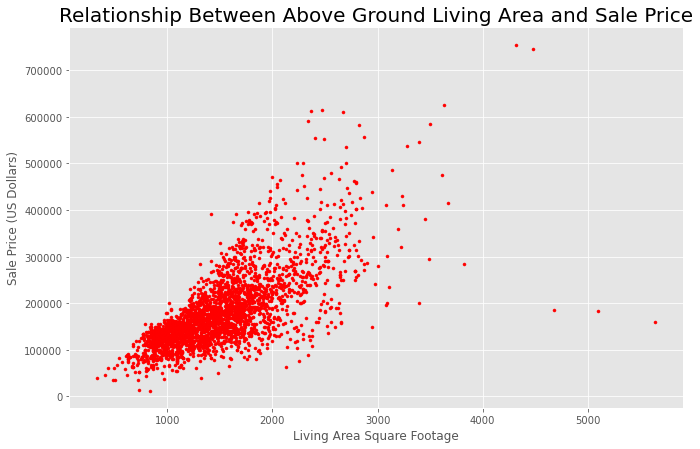

In [45]:

fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(amesH_data['Gr Liv Area'],amesH_data['SalePrice'], c='red', marker='.')
plt.title('Relationship Between Above Ground Living Area and Sale Price', fontsize=20)
plt.xlabel('Living Area Square Footage')
plt.ylabel('Sale Price (US Dollars)')
plt.show()

There are, however, some extreme outliers - specifically 3 houses with square footage over 4500.

In [46]:
amesH_data[(amesH_data['Gr Liv Area'] > 4500)]

MS SubClass MS Zoning  Lot Frontage  Lot Area  Street  Alley  Lot Shape  \
1498       MSC60        RL     313.00000     63887       2      0          1   
2180       MSC20        RL     128.00000     39290       2      0          3   
2181       MSC60        RL     130.00000     40094       2      0          3   

     Land Contour  Utilities Lot Config  Land Slope Neighborhood Condition 1  \
1498          Bnk          4     Corner           3      Edwards       Feedr   
2180          Bnk          4     Inside           3      Edwards        Norm   
2181          Bnk          4     Inside           3      Edwards        PosN   

     Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
1498        Norm      1Fam      2Story            10             5   
2180        Norm      1Fam      1Story            10             5   
2181        PosN      1Fam      2Story            10             5   

      Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
1498        2008            2008        Hip   ClyTile       Stucco   
2180        2008            2009        Hip   CompShg      CemntBd   
2181        2007            2008        Hip   CompShg      CemntBd   

     Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter Qual  Exter Cond  \
1498       Stucco        Stone     796.00000           5           3   
2180      CmentBd        Stone    1224.00000           5           3   
2181      CmentBd        Stone     762.00000           5           3   

     Foundation  Bsmt Qual  Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  \
1498      PConc          5          3              3               6   
2180      PConc          5          3              3               6   
2181      PConc          5          3              3               6   

      BsmtFin SF 1  BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
1498    5644.00000               1       0.00000    466.00000     6110.00000   
2180    4010.00000               1       0.00000   1085.00000     5095.00000   
2181    2260.00000               1       0.00000    878.00000     3138.00000   

     Heating  Heating QC Central Air  Electrical  1st Flr SF  2nd Flr SF  \
1498    GasA           5           Y           4        4692         950   
2180    GasA           5           Y           4        5095           0   
2181    GasA           5           Y           4        3138        1538   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
1498                0         5642         2.00000         0.00000          2   
2180                0         5095         1.00000         1.00000          2   
2181                0         4676         1.00000         0.00000          3   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr  Kitchen Qual  TotRms AbvGrd  \
1498          1              3              1             5             12   
2180          1              2              1             5             15   
2181          1              3              1             5             11   

      Functional  Fireplaces  Fireplace Qu Garage Type  Garage Yr Blt  \
1498           8           3             4      Attchd     2008.00000   
2180           8           2             4      Attchd     2008.00000   
2181           8           1             4     BuiltIn     2007.00000   

      Garage Finish  Garage Cars  Garage Area  Garage Qual  Garage Cond  \
1498              3      2.00000   1418.00000            3            3   
2180              3      3.00000   1154.00000            3            3   
2181              3      3.00000    884.00000            3            3   

      Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
1498            2           214            292               0           0   
2180            2           546            484               0           0   
2181            2           208            406               0           0   

      Screen Porch  Pool Area  Pool QC  Fence Misc F

There is also a linear relationship between Lot Area and Sale Price.  

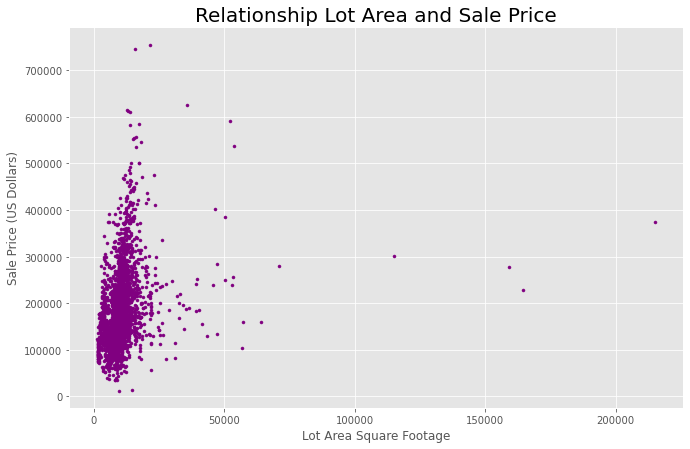

In [47]:
fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(amesH_data['Lot Area'],amesH_data['SalePrice'], c='purple', marker='.')
plt.title('Relationship Lot Area and Sale Price', fontsize=20)
plt.xlabel('Lot Area Square Footage')
plt.ylabel('Sale Price (US Dollars)')
plt.show()

Again there are a number of outliers especially the 4 values greater than 100000

In [48]:
amesH_data[amesH_data['Lot Area']>100000]

MS SubClass MS Zoning  Lot Frontage  Lot Area  Street  Alley  Lot Shape  \
956        MSC20        RL     150.00000    215245       2      0          1   
1570       SC190        RL           NaN    164660       1      0          3   
2071       MSC20        RL           NaN    115149       2      0          2   
2115       MSC50        RL           NaN    159000       2      0          2   

     Land Contour  Utilities Lot Config  Land Slope Neighborhood Condition 1  \
956           Low          4     Inside           1       Timber        Norm   
1570          HLS          4     Corner           1       Timber        Norm   
2071          Low          4    CulDSac           1      ClearCr        Norm   
2115          Low          4    CulDSac           1      ClearCr        Norm   

     Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
956         Norm      1Fam      1Story             7             5   
1570        Norm    2fmCon      1.5Fin             5             6   
2071        Norm      1Fam      1Story             7             5   
2115        Norm      1Fam      1.5Fin             6             7   

      Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
956         1965            1965        Hip   CompShg      BrkFace   
1570        1965            1965      Gable   CompShg      Plywood   
2071        1971            2002      Gable   CompShg      Plywood   
2115        1958            2006      Gable   CompShg      Wd Sdng   

     Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter Qual  Exter Cond  \
956       BrkFace         None       0.00000           3           3   
1570      Plywood         None       0.00000           3           3   
2071      Plywood        Stone     351.00000           3           3   
2115      HdBoard       BrkCmn     472.00000           4           3   

     Foundation  Bsmt Qual  Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  \
956      CBlock          4          3              3               5   
1570     CBlock          3          3              3               5   
2071     CBlock          4          3              3               6   
2115     CBlock          4          3              3               3   

      BsmtFin SF 1  BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
956     1236.00000               3     820.00000     80.00000     2136.00000   
1570    1249.00000               4     147.00000    103.00000     1499.00000   
2071    1219.00000               1       0.00000    424.00000     1643.00000   
2115     697.00000               1       0.00000    747.00000     1444.00000   

     Heating  Heating QC Central Air  Electrical  1st Flr SF  2nd Flr SF  \
956     GasW           3           Y           4        2036           0   
1570    GasA           5           Y           4        1619         167   
2071    GasA           3           Y           4        1824           0   
2115    GasA           4           Y           4        1444         700   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
956                 0         2036         2.00000         0.00000          2   
1570                0         1786         2.00000         0.00000          2   
2071                0         1824         1.00000         0.00000          2   
2115                0         2144         0.00000         1.00000          2   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr  Kitchen Qual  TotRms AbvGrd  \
956           0              3              1             3              8   
1570          0              3              1             3              7   
2071          0              2              1             4              5   
2115          0              4              1             4              7   

      Functional  Fireplaces  Fireplace Qu Garage Type  Garage Yr Blt  \
956            8           2             4      Attchd     1965.00000   
1570           8           2             4      Attchd

There is a linear relationship for the most part between Total Basement Square Footage and Sale Price.  It does not appear to be quite as tight and there are a lot of 0 values.

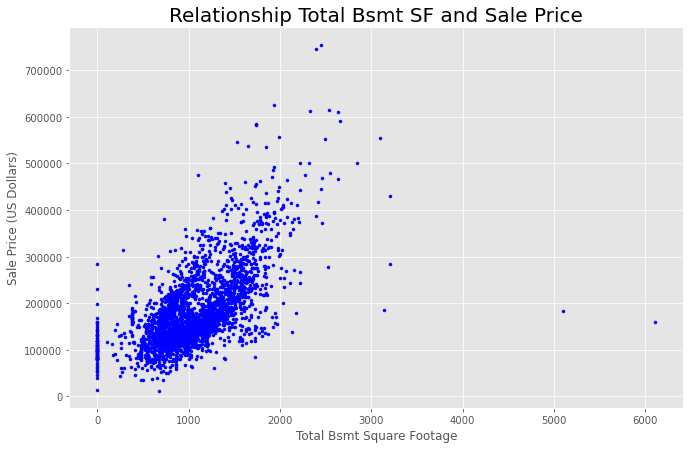

In [49]:
fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(amesH_data['Total Bsmt SF'],amesH_data['SalePrice'], c='Blue', marker='.')
plt.title('Relationship Total Bsmt SF and Sale Price', fontsize=20)
plt.xlabel('Total Bsmt Square Footage')
plt.ylabel('Sale Price (US Dollars)')
plt.show()

This plot between Garage Area and Sale Price seems quite similar in shape to the scatter plot for Total Basement Square Footage and Sale Price but more spread out.  It seems to be a fairly linear relationship with quite a few zero values.

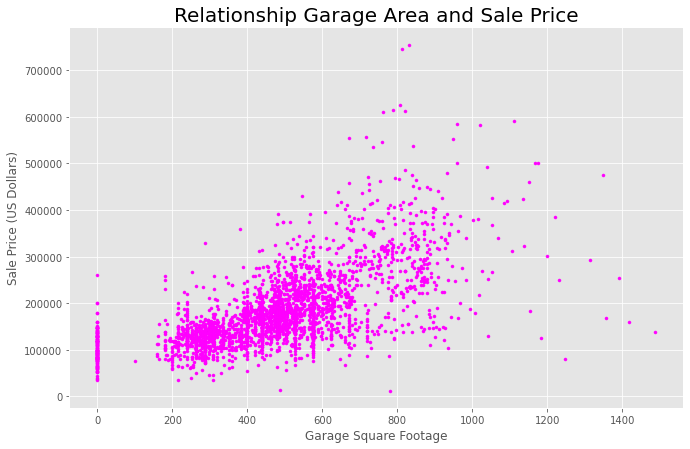

In [50]:
fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(amesH_data['Garage Area'],amesH_data['SalePrice'], c='Magenta', marker='.')
plt.title('Relationship Garage Area and Sale Price', fontsize=20)
plt.xlabel('Garage Square Footage')
plt.ylabel('Sale Price (US Dollars)')
plt.show()

In the last of the scatter plots, I wanted to see what plot would result if AboveGrade Living Area and Total Basement Square Footage were combined.  The result is interesting as it shows a very strong linear relationship between Total Square Footage and Sale Price.

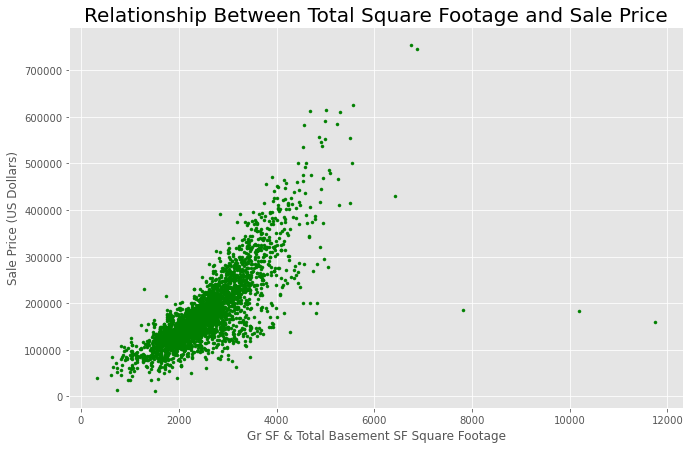

In [51]:
fig, ax = plt.subplots(figsize=(11,7))
plt.scatter((amesH_data['Gr Liv Area']+amesH_data['Total Bsmt SF']),amesH_data['SalePrice'], c='green', marker='.')
plt.title('Relationship Between Total Square Footage and Sale Price', fontsize=20)
plt.xlabel('Gr SF & Total Basement SF Square Footage')
plt.ylabel('Sale Price (US Dollars)')
plt.show()

### Boxplots Showing Relationship Between Categorical Variables of Interest and Sale Price

#### House Style
First we take a look at the relationship between House Style and Sale Price.  We can see that it is possible to purchase nearly any style of home for a price in a band of about $140,000 to $200,000 in Ames.  The price band for one-story and two-story homes varies considerably starting under $50,0000 and going up to the mid-$300,000s.  Interestingly, while 2.5 Finished and 2.5 Unfinished price bands are higher than that for 2Story homes, 2Story homes have a significantly higher ceiling.  The remaining house styles have relatively tighter pricing bands.

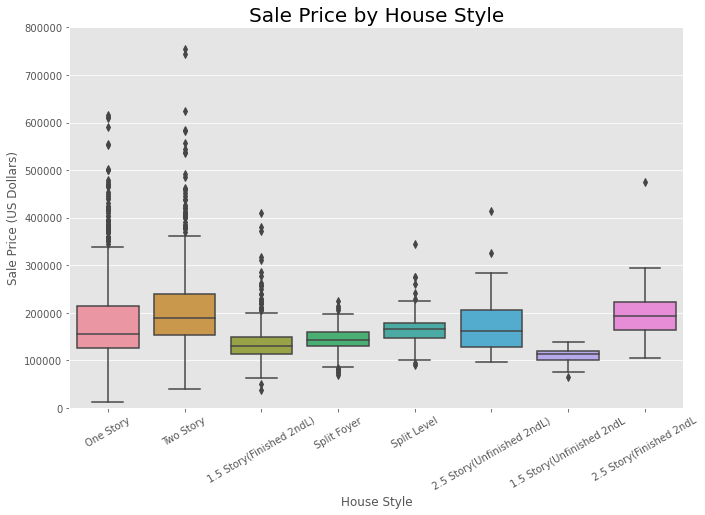

In [52]:
var = 'House Style'
data = pd.concat([amesH_data['SalePrice'], amesH_data[var]], axis =1)
f, ax = plt.subplots(figsize=(11, 7))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
ax.set_title('Sale Price by House Style', fontsize=20)
plt.ylabel('Sale Price (US Dollars)')
plt.xticks([0,1,2,3,4,5,6,7], ['One Story', 'Two Story', '1.5 Story(Finished 2ndL)', 'Split Foyer', 'Split Level', '2.5 Story(Unfinished 2ndL)', '1.5 Story(Unfinished 2ndL', '2.5 Story(Finished 2ndL'], rotation=30)
plt.show()

#### Neighborhood
Next we look at Neighborhood.  Immediately it is apparent that Stone Brook, Northridge Heights, and Northridge are the priciest neighborhoods with median home prices over $300,000.  Greenhills is only slightly cheaper.  Otherwise, homes can be purchased in most neighborhoods within our price band of $150,000 to $200,000.  Aside from the upper class areas, only the upper-middle class neighborhoods of Somerset,Timber,Veenker and College Crescent have median prices above the $200,000 mark.  Cheaper neighborhoods are Briardale, Meadow Village, Brookside, Old Town, Edwards, and South West of Iowa State University.  It makes sense that Iowa DOT and Railroad is the cheapest place to buy a house in Ames.

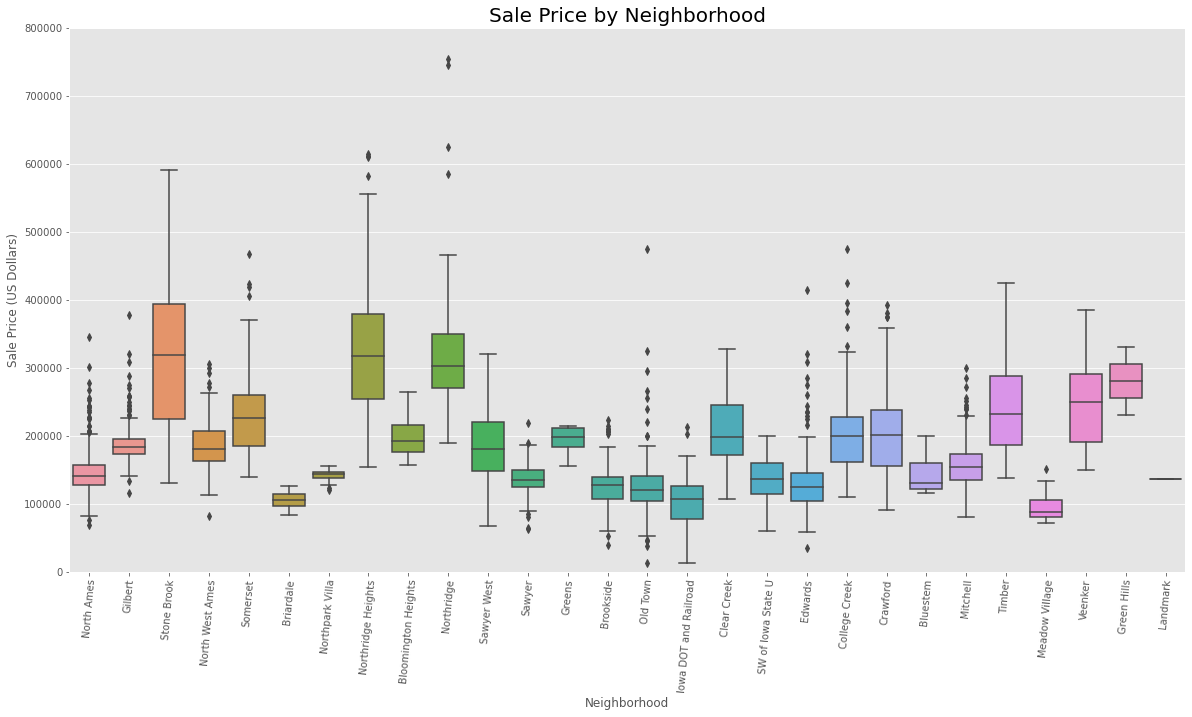

In [53]:
neighborhoods=['North Ames', 'Gilbert', 'Stone Brook', 'North West Ames', 'Somerset', 'Briardale', 'Northpark Villa', 'Northridge Heights', 'Bloomington Heights', 'Northridge', 'Sawyer West', 'Sawyer', 'Greens', 'Brookside', 'Old Town', 'Iowa DOT and Railroad','Clear Creek', 'SW of Iowa State U', 'Edwards', 'College Creek', 'Crawford', 'Bluestem', 'Mitchell', 'Timber', 'Meadow Village', 'Veenker', 'Green Hills', 'Landmark']
var = 'Neighborhood'
data = pd.concat([amesH_data['SalePrice'], amesH_data[var]], axis =1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
ax.set_title('Sale Price by Neighborhood', fontsize=20)
plt.ylabel('Sale Price (US Dollars)')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], neighborhoods, rotation=85)
plt.show()

This chart gives us a different perspective on Neighborhood by showing the average price by neighborhood and the frequency of homes along with a median line that allows us to compare the median home price in all of Ames.

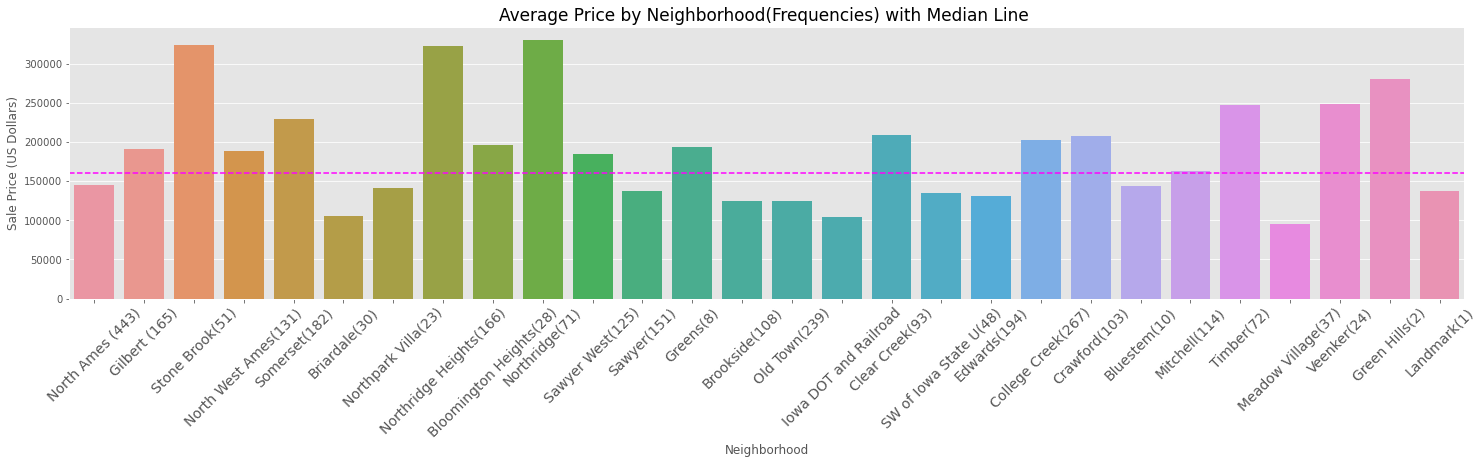

In [54]:
var = 'Neighborhood'
counts = amesH_data['Neighborhood'].value_counts()#.rename_axis('neighborhood').reset_index(name='count')
c=counts.to_dict()
neighborhoods=[f'North Ames ({c["NAmes"]})', f'Gilbert ({c["Gilbert"]})', f'Stone Brook({c["StoneBr"]})', f'North West Ames({c["NWAmes"]})', f'Somerset({c["Somerst"]})', f'Briardale({c["BrDale"]})', f'Northpark Villa({c["NPkVill"]})', f'Northridge Heights({c["NridgHt"]})', f'Bloomington Heights({c["Blmngtn"]})', f'Northridge({c["NoRidge"]})', f'Sawyer West({c["SawyerW"]})', f'Sawyer({c["Sawyer"]})', f'Greens({c["Greens"]})', f'Brookside({c["BrkSide"]})', f'Old Town({c["OldTown"]})', f'Iowa DOT and Railroad',f'Clear Creek({c["IDOTRR"]})', f'SW of Iowa State U({c["SWISU"]})', f'Edwards({c["Edwards"]})', f'College Creek({c["CollgCr"]})', f'Crawford({c["Crawfor"]})', f'Bluestem({c["Blueste"]})', f'Mitchell({c["Mitchel"]})', f'Timber({c["Timber"]})', f'Meadow Village({c["MeadowV"]})', f'Veenker({c["Veenker"]})', f'Green Hills({c["GrnHill"]})', f'Landmark({c["Landmrk"]})']

data = pd.concat([amesH_data['SalePrice'], amesH_data[var]], axis =1)
f,ax= plt.subplots(figsize=(25,5))
fig = sns.barplot(var, 'SalePrice', data=data, ci=None)
ax.set_title('Average Price by Neighborhood(Frequencies) with Median Line ', fontsize=17)
#ax.bar_label(conatainers[0])
plt.ylabel('Sale Price (US Dollars)')
plt.axhline(amesH_data['SalePrice'].median(), color='magenta', linestyle='dashed')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], neighborhoods, rotation=45, fontsize=14)

plt.show()

#### Zoning
We can see that while homes in Residential Low-Density have a wider price-band, they generally tend to have higher prices than Residential High-Density and Residential Medium-Density.  The Floating Village zoning has the highest prices. (Note: Floating Village here refers to a type of planned community with various amenities built-in to the neighborhood)

Not surprisingly, homes that are in Commercial, Industrial or Agricultural zones tend to be cheaper.

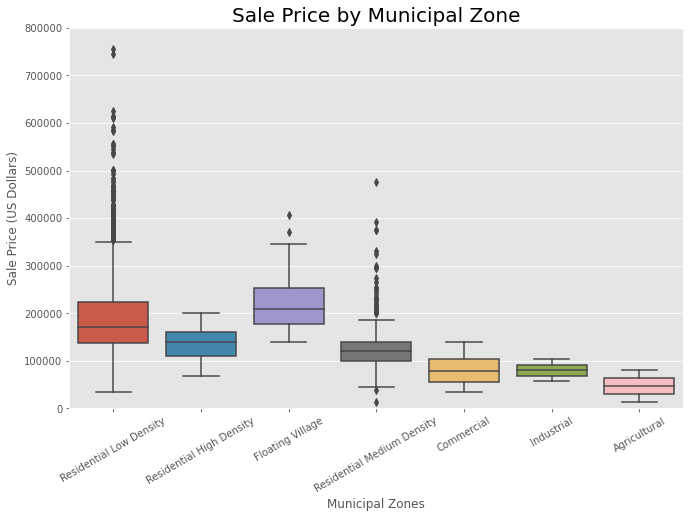

In [55]:
var = 'MS Zoning'
data = pd.concat([amesH_data['SalePrice'], amesH_data[var]], axis =1)
f, ax = plt.subplots(figsize=(11,7))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
ax.set_title('Sale Price by Municipal Zone', fontsize=20)
plt.xlabel('Municipal Zones')
plt.ylabel('Sale Price (US Dollars)')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Residential Low Density','Residential High Density', 'Floating Village', 'Residential Medium Density', 'Commercial', 'Industrial', 'Agricultural'], rotation=30)
plt.show()

### Looking at A Few Time Related Features

Here we can see the majority of homes sold in Ames between 2006 and 2010 were built since the 1960s with a considerable number built around the turn of the millennium.

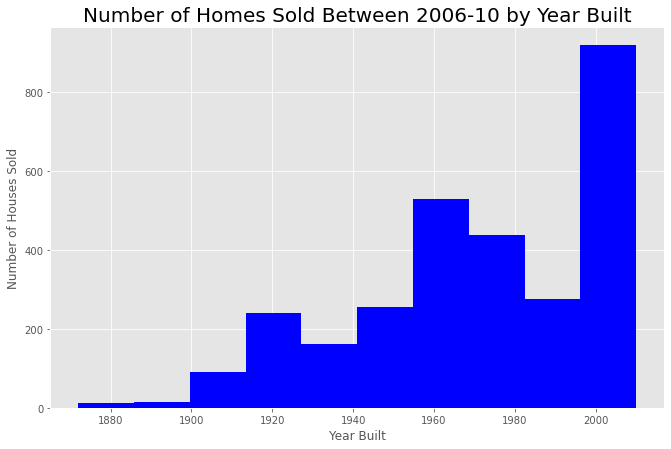

In [56]:
ax = amesH_data.hist(column='Year Built', figsize=(11,7),color='blue')

ax = ax[0]
for x in ax:
    x.set_title('Number of Homes Sold Between 2006-10 by Year Built', fontsize=20)
    x.set_xlabel('Year Built')
    x.set_ylabel('Number of Houses Sold')



This set of boxplots gives us a bit more detail in terms of the price of a home depending on year built.  As is perhaps obvious, newer homes tend to be more expensive.  It is interesting though that houses built in 1892 seem to fetch higher prices than we might expect.

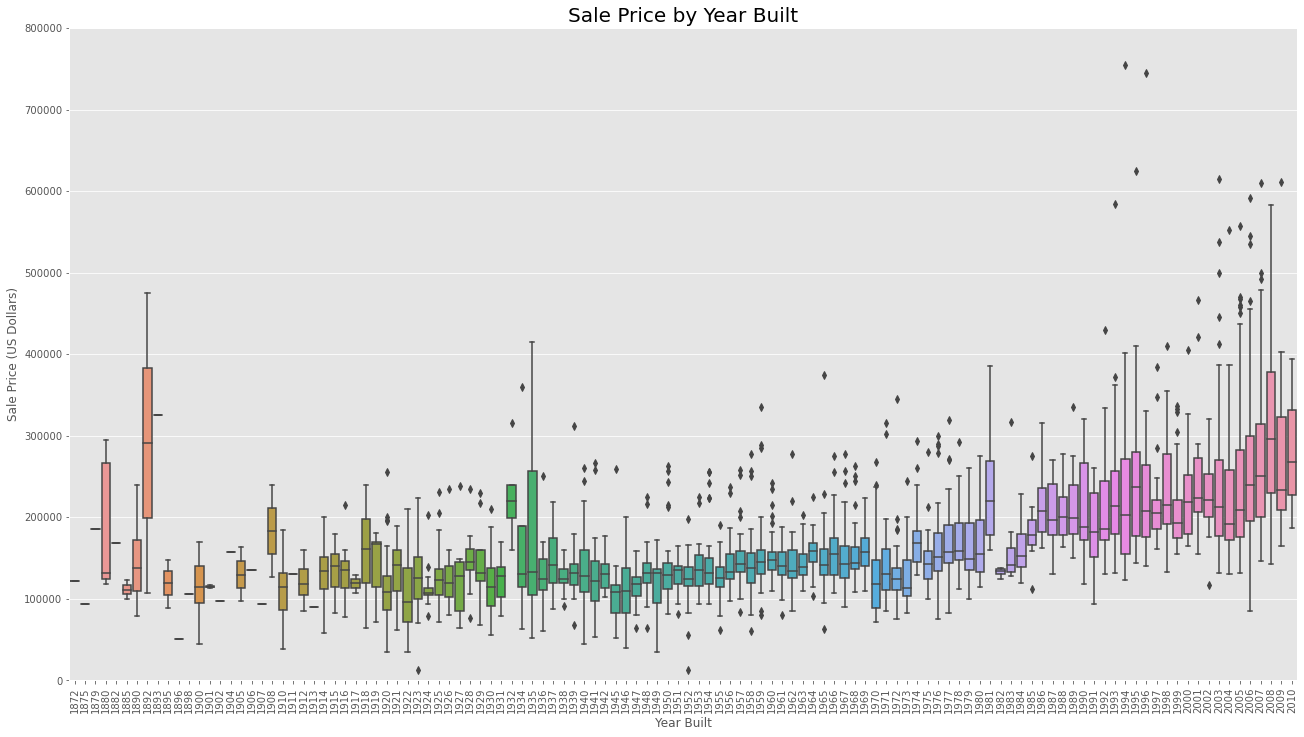

In [57]:
var = 'Year Built'
data = pd.concat([amesH_data['SalePrice'], amesH_data[var]], axis =1)
f, ax = plt.subplots(figsize=(22, 12))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
ax.set_title('Sale Price by Year Built', fontsize=20)
plt.ylabel('Sale Price (US Dollars)')
plt.xticks(rotation=90)
plt.show()

In this chart we can see that house prices actually tend to decline in Ames in the 2006-2010 period with a fall in prices since 2007 which corresponds to the beginning of the US Housing Finance Crisis.  

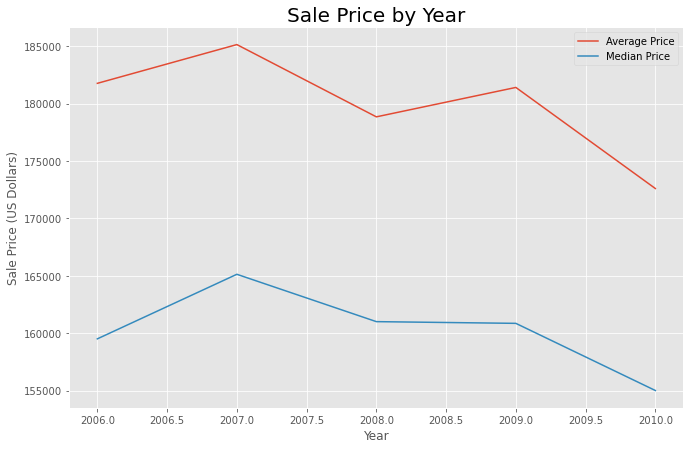

In [58]:
avg_price = amesH_data.groupby('Yr Sold')['SalePrice'].agg(np.average)
med_price = amesH_data.groupby('Yr Sold')['SalePrice'].agg(np.median)
f, ax = plt.subplots(figsize=(11,7))
plt.plot(avg_price, label='Average Price')
plt.plot(med_price, label='Median Price')
plt.legend(loc='upper right')
plt.title('Sale Price by Year', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Sale Price (US Dollars)')
plt.show()

This period is significantly different than the long-term housing price trend in Iowa.  As we can see in this graph provided by the Federal Reserve.

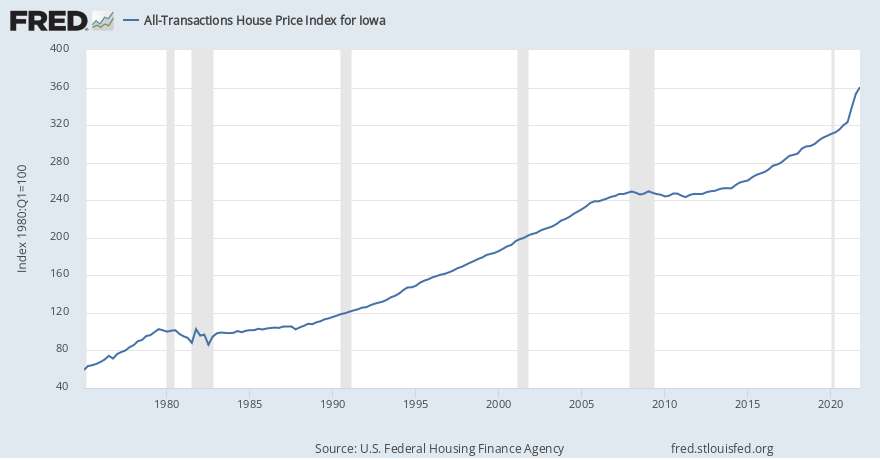

In [59]:
from IPython.display import Image
Image('images/fredgraphIowa.png')

### Frequency Distributions and Histograms

Looking at the frequency distribution of Sale Price we can see that our target variable has a significant right-skew.

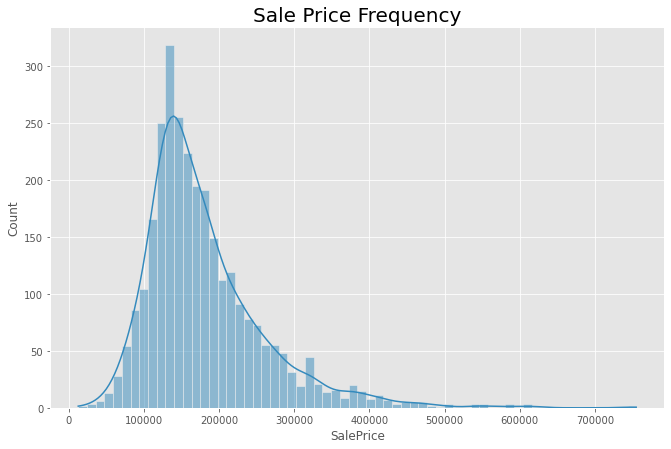

In [60]:
plt.figure(figsize=(11,7))
sns.histplot(data=amesH_data['SalePrice'], kde=True).set_title('Sale Price Frequency', fontsize=20)
plt.show()


The probability plot confirms that SalePrice does not follow a normal distribution

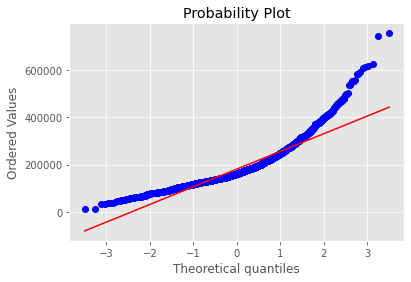

<Figure size 792x504 with 0 Axes>

In [61]:
from scipy.stats import probplot
probplot(amesH_data['SalePrice'], plot=plt)
plt.figure(figsize=(11,7))
plt.show()

I attempted to perform a log transformation on both the target variable (Sale Price) and significantly skewed independent variables.  However, this resulted in both warnings and exceptions elsewhere in the code.  This might be because log(x) approaches negative infinity as the value of x becomes closer to zero.
(see http://onbiostatistics.blogspot.com/2012/05/logx1-data-transformation.html)

As an alternative, I utilized a log(x+1) transformation.
(see https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models)

This shifts the distribution to the right resulting in greater normality.

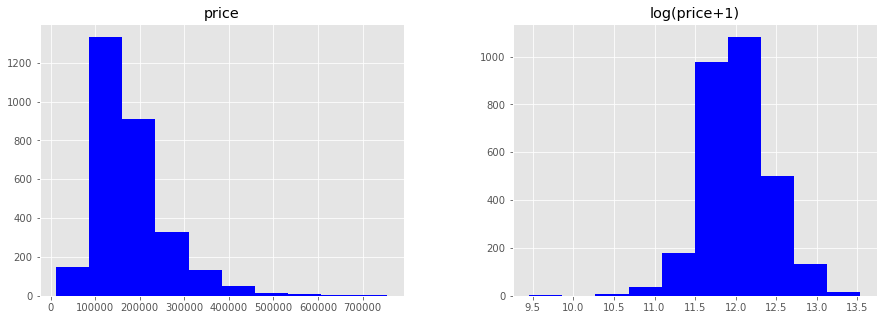

In [62]:
price = pd.DataFrame({'price':amesH_data['SalePrice'], 'log(price+1)':np.log1p(amesH_data['SalePrice'])})
price.hist(figsize=(15,5), color='blue')
plt.show()

Looking at our histograms of discrete and continuous variables, we can see that most of the continuous features are right-skewed.  It would be good then to transform the most skewed of these variables using log(price+1) as we will do with our target variable.

There are a lot of discrete features (along with Mas Vnr Area) that are dominated by 0 values.  This makes sense as in most cases homes do not have a pool or an enclosed porch.  Nevertheless, it is probably doubtful that these zero dominated features will be important when developing our predictive models.

In [64]:
a_N = pd.concat([amesH_data[contFeat], amesH_data[discFeat], target], axis=1)
a_Ncorr = a_N.corr()

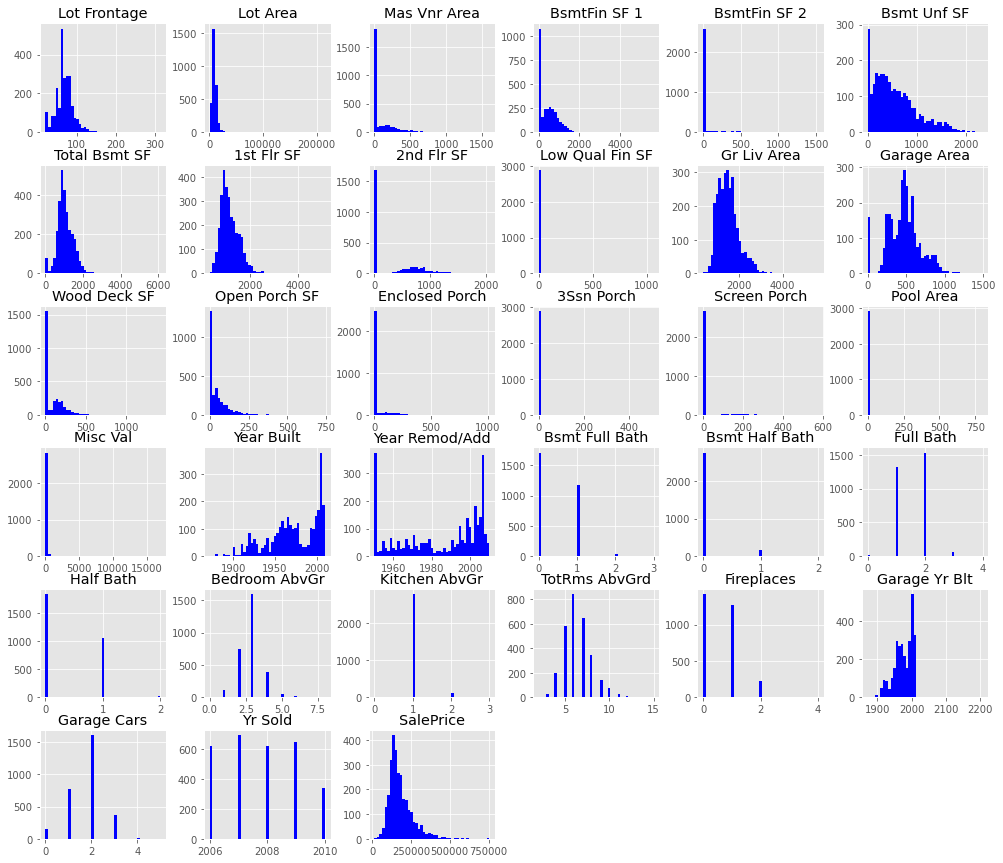

In [66]:

a_N.hist(bins=45, figsize=(17,15), color='blue')

plt.show()

I thought I would check a couple of individual histograms to see if any more detail emerges if we zoom in.  We can see a bit more detail for these two features distributions but really the large number of zero values predominates.

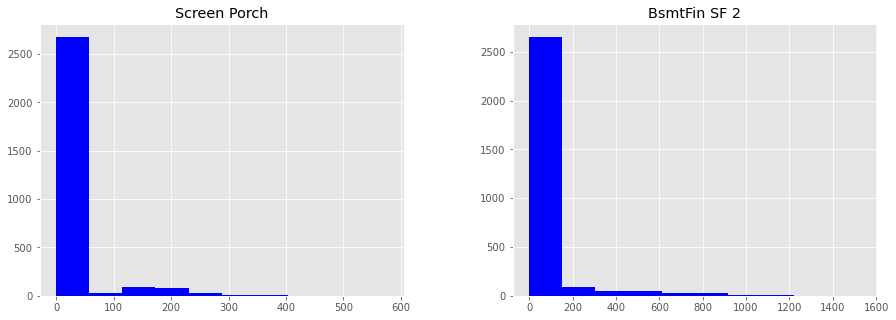

In [67]:
price = pd.DataFrame({'Screen Porch':amesH_data['Screen Porch'], 'BsmtFin SF 2':amesH_data['BsmtFin SF 2']})

price.hist(figsize=(15,5), color='blue')
plt.show()


### Correlation Matrices

We begin by looking at an extremely large correlation matrix which includes all features in our data set.

While it is a bit chaotic, a few things stand out.  First, there are some features which have a high level of collinearity.  Most are fairly easy to understand:
Positive:
Pool Area & Pool Quality
Garage Quality & Garage Condition
Garage Area & Garage Cars
Year Built & Year Garage Built
Total Rooms Above Ground & Total Area Above Ground
Basement Finish Type Square Footage & Basement Type Square Footage

Negative:
Basement Unfinished Square Footage & Basement Full Bathrooms
Basement Unifinished Square Footage & Basement Finish Type Square footage
Year Built & Overall Condition


A bit more interesting is the close relationship between Total Basement Square Footage and First Floor Square Footage.

As well, there is a negative relationship between Enclosed Porch and Year Built.

In [68]:
amesCorr = amesH_data.corr()

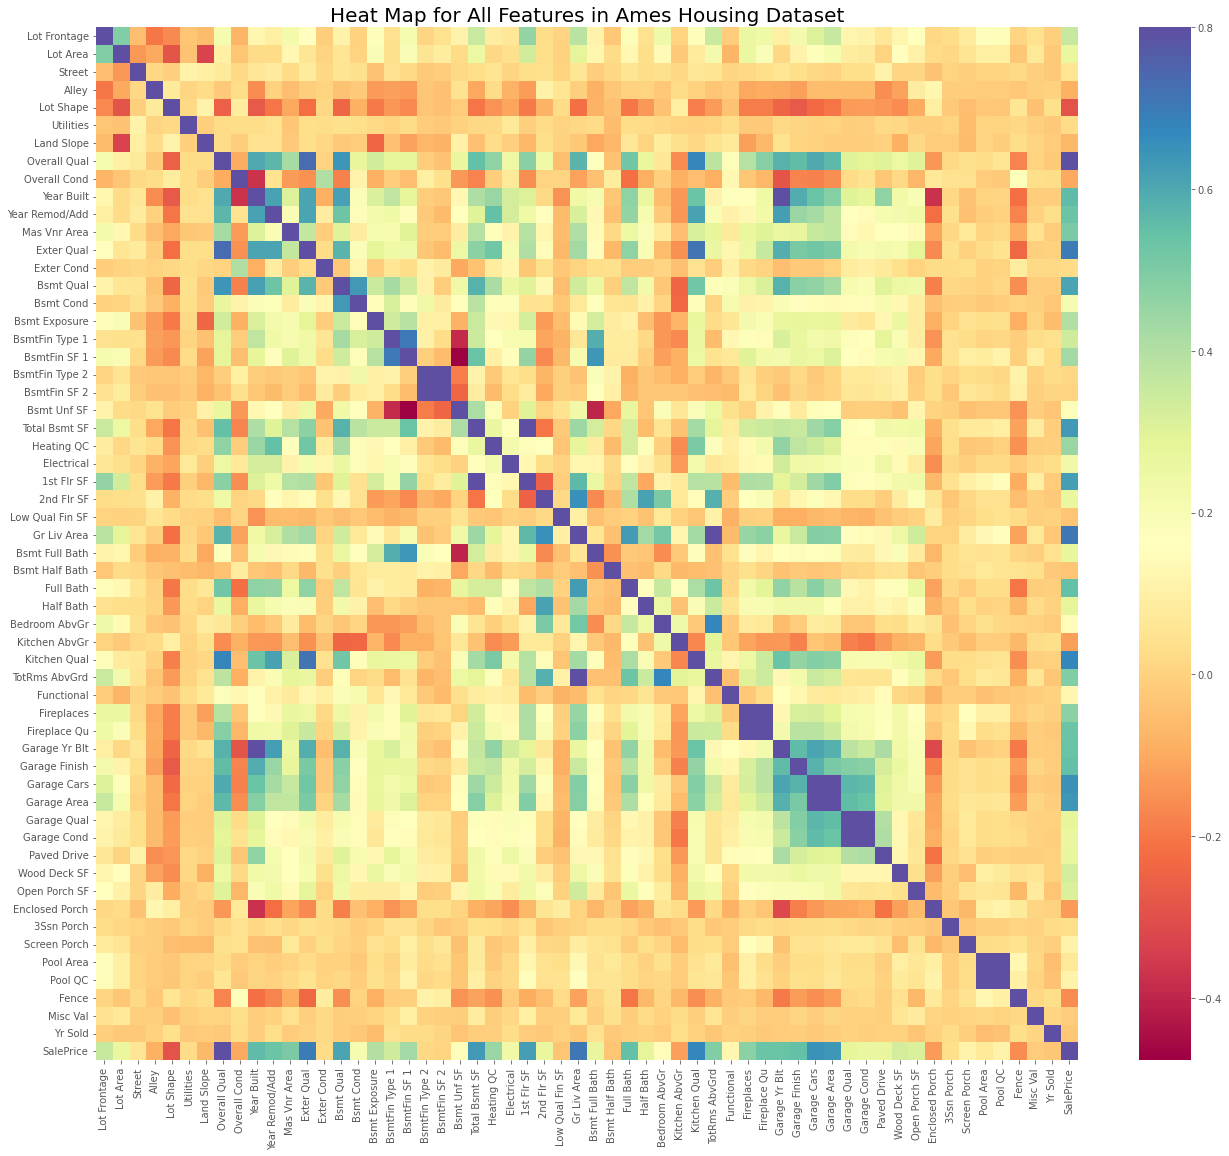

In [69]:
f, ax = plt.subplots(figsize=(22,19))
cmap = sns.color_palette('Spectral', as_cmap=True)
#cmap = sns.diverging_palette(145,300, l=65, center='dark',as_cmap = True)
ax.set_title('Heat Map for All Features in Ames Housing Dataset', fontsize=20)
sns.heatmap(amesCorr, vmax=0.8, cmap=cmap)
plt.show()

#### Matrix of 21 Features Most Correlated with Target 

Next we zoom in to look specifically at the 21 features with the highest level of correlation with our target variable - Sale Price.  

We see that there are very strong correlations between Total Indoor Square Footage, Overall Quality, and AboveGround Living Area Square Footage.



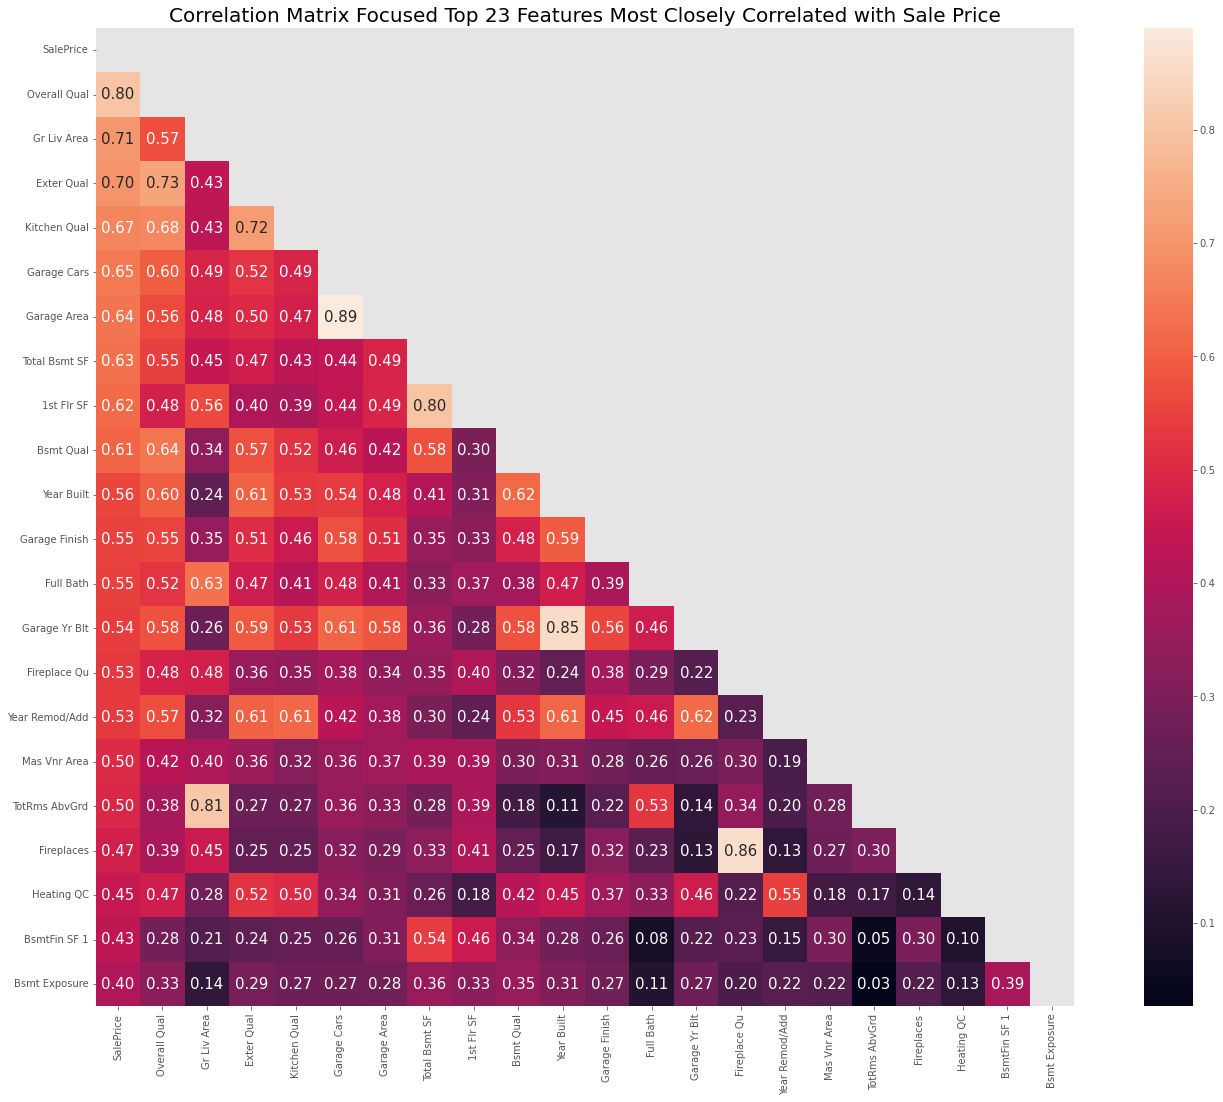

In [70]:
n = 22
top_corr = amesCorr.nlargest(n, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(amesH_data[top_corr].values.T)
n2=10
ten_corr = amesCorr.nlargest(n2, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(amesH_data[top_corr].values.T)
f, ax = plt.subplots(figsize=(25,18))
#sns.set(font_scale=1.25)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
hm = sns.heatmap(cm, cbar=True, annot=True , square=True, fmt='.2f', annot_kws={'size':15}, yticklabels=top_corr.values, xticklabels=top_corr.values, mask=mask)
ax.set_title('Correlation Matrix Focused Top 23 Features Most Closely Correlated with Sale Price', fontsize=20)
plt.show()


### Numeric Feature Correlation Matrix

Here we can again see problems of multicollinearity.  
Particularly problematic are:
Positive
Garage Area and Garage Cars
Total Basement Square Footage and 1st Flr Square Footage
Total Rooms Above Ground and AboveGround Living Area

Negative
Basement Unfinished Square Footage and Basement Finished Square Footage
Basement Unfinshed Square Footage and Basement Full Bathrooms

We also see significant collinearity between Total Indoor Square Footage and AboveGround Living Area Square Footage, Total Basement Square Footage and 1st Floor Square Footage.





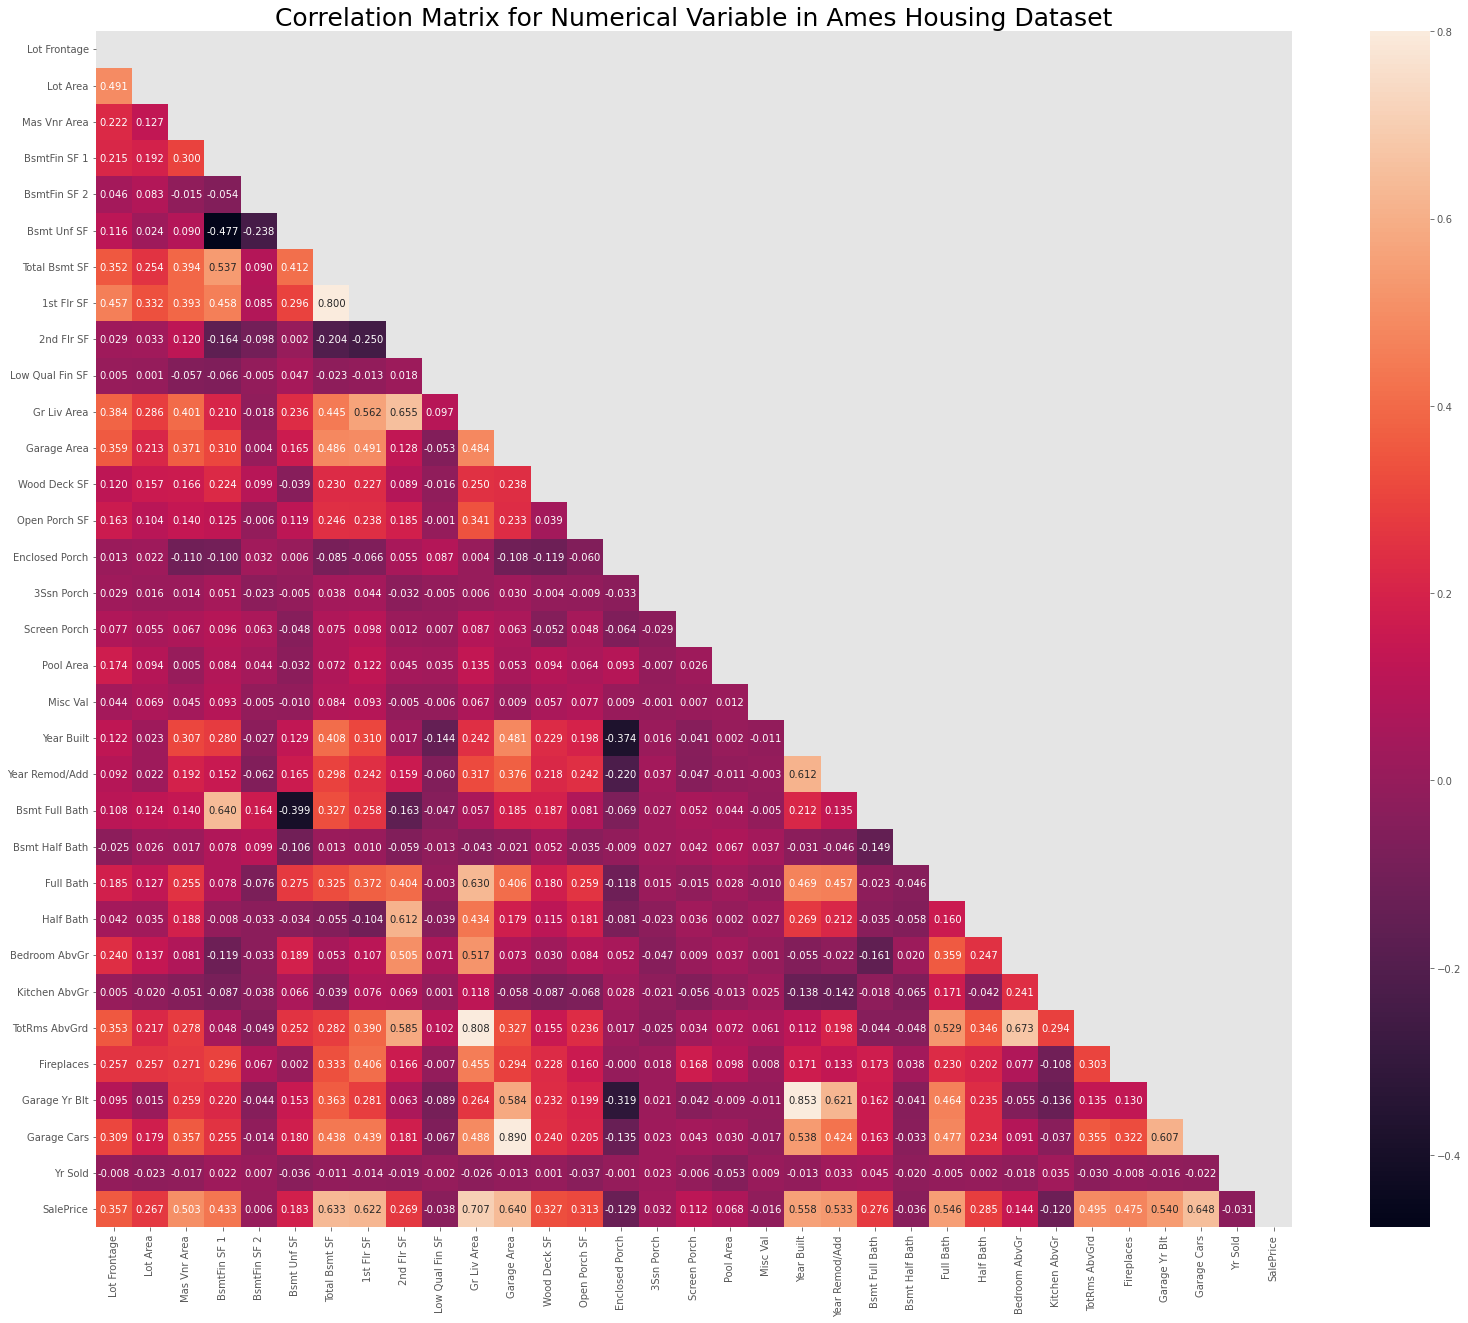

In [71]:
f, ax = plt.subplots(figsize=(28,22))
#mask = np.triu(np.ones_like(a_Ncorr,dtype=np.bool))
mask = np.zeros_like(a_Ncorr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(a_Ncorr, vmax=0.8, annot=True, mask=mask, square=True, fmt='.3f', annot_kws={'size':10})
ax.set_title('Correlation Matrix for Numerical Variable in Ames Housing Dataset', fontsize=25)
plt.show()

### Categorical Feature Correlation Matrix Using Kendall Rank Method
Our correlation matrix using the Kendall Rank correlation for categorical features suggests that there is not a lot of monotonicity between categorical features.

The only variables that show a degree of monotonicity are Kitchen Quality with External Quality and Garage Condition with Garage Quality.

In [72]:
ames_C=pd.concat([amesH_data[ordF], amesH_data[nomF], amesH_data['SalePrice']], axis=1)
a_Ccorr = ames_C.corr(method='kendall')

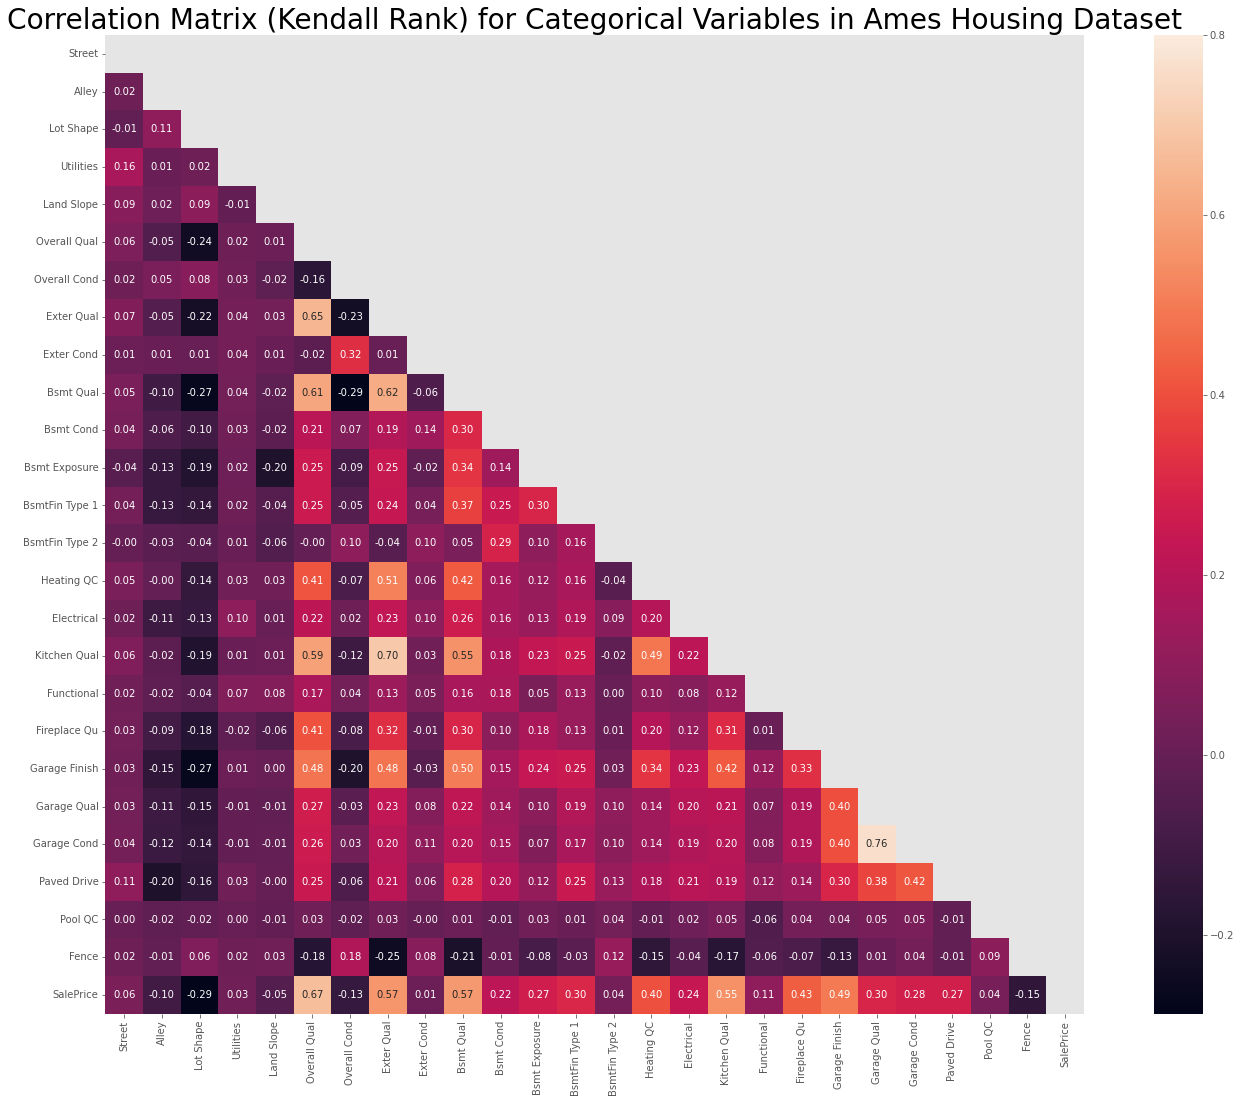

In [73]:
f, ax = plt.subplots(figsize=(25,18))
mask = np.zeros_like(a_Ccorr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(a_Ccorr, vmax=0.8, square=True, annot=True, mask=mask, fmt='.2f')
ax.set_title('Correlation Matrix (Kendall Rank) for Categorical Variables in Ames Housing Dataset', fontsize=28)
plt.show()


The last thing that I wanted to do with the EDA was a quick pair plot just to get another look a bunch of the key variables.

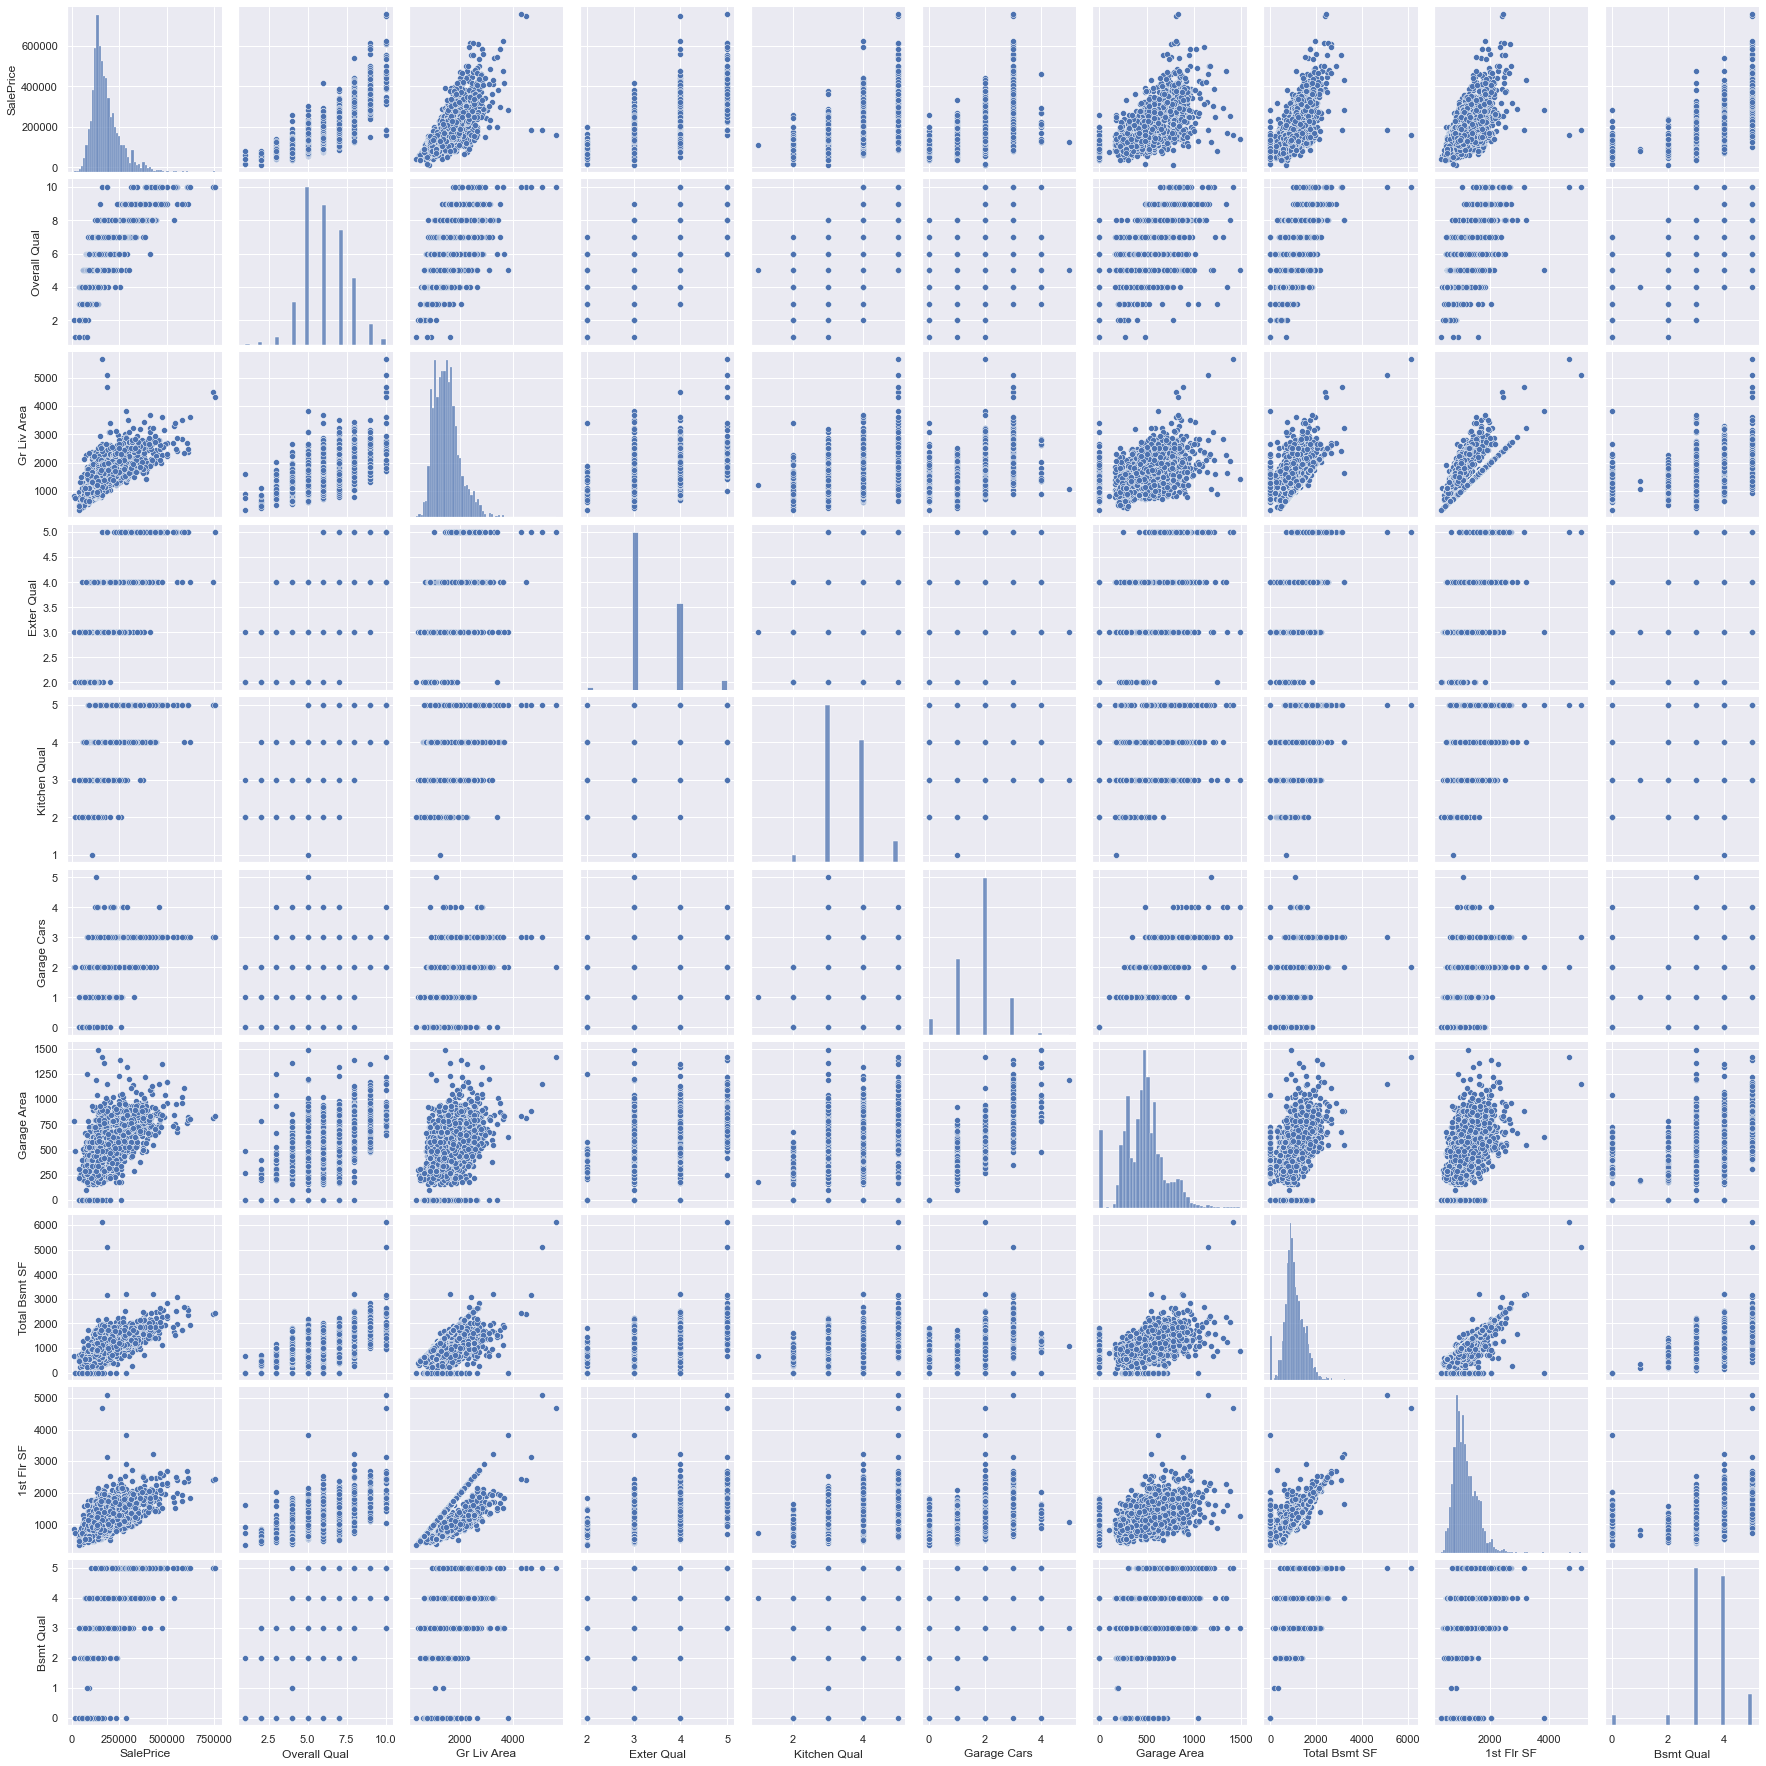

In [74]:
sns.set()
sns.pairplot(amesH_data[ten_corr], height=2.5, grid_kws=dict(diag_sharey=False))
plt.show()

## 3. Data Preparation II

First, I remove extreme outliers as well as the 1st and 99th percentile of SalePrice.  Next, I consolidate the levels of several nominal variables. I separate our dataset into object and nonObject features.  I use a KNN imputer to fill the Na values for Lot Frontage.  Make a quick check to make sure there are no Na values.  I then one-hot encode the object features using .getdummies.

Next I take a brief look at some of the most skewed features among the nonObject features before performing log(price+1) transformation for features with greater than 0.6 abs skew value.

Finally, I perform a log(price+1) transformation on the target variable.

In [75]:
# Remove Outliers
amesH_data = amesH_data[amesH_data['Gr Liv Area'] < 4500]
amesH_data = amesH_data[amesH_data['Lot Area'] < 100000]
amesH_data = amesH_data[amesH_data['Total Bsmt SF'] < 5000]
amesH_data = amesH_data[amesH_data['Garage Yr Blt'] < 2011]

In [76]:
OutlierMinMax = np.quantile(amesH_data['SalePrice'], (.01,.99))
print(OutlierMinMax)
print(len(amesH_data[(amesH_data['SalePrice']<OutlierMinMax[0]) | (amesH_data['SalePrice'] > OutlierMinMax[1])]))
amesH_data = amesH_data[(amesH_data['SalePrice'] > OutlierMinMax[0]) & (amesH_data['SalePrice'] < OutlierMinMax[1])]

[ 61685.43 456854.13]
60


The index needs to be reset after removing records

In [77]:
amesH_data=amesH_data.reset_index(drop='True')

In [78]:
amesH_data.shape

(2862, 80)

In [79]:
target = amesH_data['SalePrice']

In [80]:
# Combining Gr Liv Area and Total Bsmt SF
amesH_data['Total SF'] = amesH_data['Gr Liv Area'] + amesH_data['Total Bsmt SF']

In [81]:
# Simplified Several Nominal Variables
amesH_data.loc[amesH_data['Neighborhood'] == 'Landmrk', 'Neighborhood'] = 'Sawyer'
amesH_data.loc[amesH_data['Neighborhood'] == 'GrnHill', 'Neighborhood'] = 'Timber'
amesH_data.loc[amesH_data['Neighborhood'] == 'Greens', 'Neighborhood'] = 'Somerst'
amesH_data.loc[amesH_data['Neighborhood'] == 'Blueste', 'Neighborhood'] = 'Crawfor'
amesH_data.loc[amesH_data['Neighborhood'] == 'NPkVill', 'Neighborhood'] = 'NAmes'
amesH_data.loc[amesH_data['Neighborhood'] == 'Veenker', 'Neighborhood'] = 'Somerst'
amesH_data.loc[amesH_data['Neighborhood'] == 'Blmngtn', 'Neighborhood'] = 'Gilbert'
amesH_data.loc[amesH_data['Neighborhood'] == 'BrDale', 'Neighborhood'] = 'NAmes'
amesH_data.loc[amesH_data['Neighborhood'] == 'MeadowV', 'Neighborhood'] = 'Mitchel'
amesH_data.loc[amesH_data['Neighborhood'] == 'ClearCr', 'Neighborhood'] = 'Edwards'
amesH_data.loc[amesH_data['Neighborhood'] == 'SWISU', 'Neighborhood'] = 'Edwards'
amesH_data.loc[amesH_data['Neighborhood'] == 'StoneBr', 'Neighborhood'] = 'Gilbert'
amesH_data.loc[amesH_data['Neighborhood'] == 'NoRidge', 'Neighborhood'] = 'NridgHt'


foundation=['BrkTil', 'Stone', 'Wood', 'Slab']
for f in foundation:
    amesH_data.loc[amesH_data['Foundation'] == f, 'Foundation'] = 'Other'



rail = ['RRNn', 'RRNe', 'RRAe', 'RRAn']
positive = ['PosA', 'PosN']

for r in rail:
    amesH_data.loc[amesH_data['Condition 1'] == r, 'Condition 1'] = 'Railway'
    amesH_data.loc[amesH_data['Condition 2'] == r, 'Condition 2'] = 'Railway'

for p in positive:
    amesH_data.loc[amesH_data['Condition 1'] == p, 'Condition 1'] = 'PositiveAm'
    amesH_data.loc[amesH_data['Condition 2'] == p, 'Condition 2'] = 'PositiveAm'


other = ['ImStucc', 'PreCast', 'Stone', 'CBlock', 'AsphShn', 'BrkComm']

for o in other:
    amesH_data.loc[amesH_data['Exterior 1st'] == o, 'Exterior 1st'] = 'Other'
    amesH_data.loc[amesH_data['Exterior 2nd'] == o, 'Exterior 2nd'] = 'Other'

I had originally filled Na values for Lot Frontage with the median but I decided later to use a KNN imputer for these values.

In [82]:
# Alternative to KNN imputer
# frontageMed = amesH_data['Lot Frontage'].median()
# amesH_data.loc[:, 'Lot Frontage'] = amesH_data.loc[:, 'Lot Frontage'].fillna(frontageMed)

In [83]:
obj_feat = amesH_data.select_dtypes(include=['object']).columns
nonObj_feat = amesH_data.select_dtypes(exclude = ['object']).columns
nonObj_feat = nonObj_feat.drop('SalePrice')

In [84]:
amesH_data_nonObjF = amesH_data[nonObj_feat]
amesH_data_objF = amesH_data[obj_feat]

In [85]:
amesH_data_objF.shape

(2862, 22)

In [86]:
amesH_data_nonObjF.shape

(2862, 58)

In [87]:
print(amesH_data_objF.isnull().values.sum())
print(amesH_data_nonObjF.isnull().values.sum())

0
484


In [88]:
#KNN imputer - impute values for Lot Frontage NAs
imputer = KNNImputer(n_neighbors=4)
imputer.fit_transform(amesH_data_nonObjF)
Frontage_Impute = imputer.transform(amesH_data_nonObjF)
amesH_data_nonObjF = pd.DataFrame(imputer.fit_transform(amesH_data_nonObjF), columns = amesH_data_nonObjF.columns)

In [89]:
print(amesH_data_nonObjF.isnull().values.sum())

0


In [90]:
skewness = amesH_data_nonObjF.apply(lambda x:skew(x))
skewness = skewness[abs(skewness) > 0.6]

In [91]:
print(skewness.sort_values().head(10))
print(skewness.sort_values().tail(20))

Utilities     -43.03017
Street        -18.83488
Functional     -5.09800
Land Slope     -5.08796
Electrical     -4.33723
Bsmt Cond      -3.57597
Garage Cond    -3.52952
Garage Qual    -3.41370
Paved Drive    -3.14173
Bsmt Qual      -1.28650
dtype: float64
Lot Frontage       0.99734
Bsmt Exposure      1.26285
Exter Cond         1.52184
Fence              1.73925
Wood Deck SF       1.80910
Open Porch SF      2.46692
Mas Vnr Area       2.56967
BsmtFin Type 2     3.13578
Lot Area           3.51691
Bsmt Half Bath     3.92933
Screen Porch       4.00615
Enclosed Porch     4.01926
BsmtFin SF 2       4.08214
Alley              4.14758
Kitchen AbvGr      4.29006
3Ssn Porch        11.26195
Low Qual Fin SF   12.32720
Pool Area         18.68478
Pool QC           18.71996
Misc Val          22.49727
dtype: float64


In [92]:
skewed_feat = skewness.index
amesH_data_nonObjF = amesH_data_nonObjF.copy()
amesH_data_nonObjF[skewed_feat] = np.log1p(amesH_data_nonObjF[skewed_feat])

In [93]:
y = target
y = np.log1p(y)


Normal probability plot shows that the log transformation has helped to make Sale Price better approximate a normal distribution.

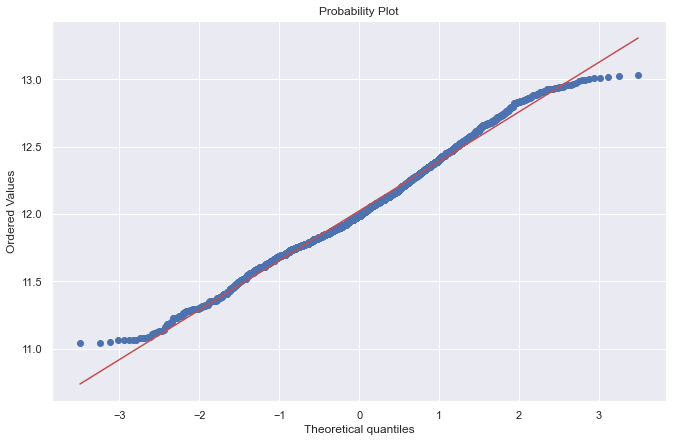

In [94]:
plt.figure(figsize=(11,7))
probplot(y, plot=plt)
plt.show()

In [95]:
amesH_data_objF=pd.get_dummies(amesH_data_objF)

In [96]:
amesH_data_nonObjF = amesH_data_nonObjF.reset_index(drop=True)
amesH_data_objF = amesH_data_objF.reset_index(drop=True)

In [97]:
print(amesH_data_objF.shape, amesH_data_nonObjF.shape)

(2862, 162) (2862, 58)


In [98]:
y.shape

(2862,)

#### Creating Test and Train Sets

We concatenate our object and nonObject features and then create train and test sets using 70% for train and 30% for test.

In [99]:
X = pd.concat([amesH_data_nonObjF, amesH_data_objF], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))


X_train: (2003, 220)
X_test: (859, 220)
y_train: (2003,)
y_test: (859,)


#### Standardization
Next we standardized our data to prevent large discrepencies in scale between various features causing distortions.  Note this is done after train/test split in order to prevent data leakage.  Also, while fit_transform is used on the X_train data, transform is used on the X_test data to again ensure no data leakage.

In [100]:
stdSc = StandardScaler()
X_train = X_train.copy()
X_test = X_test.copy()
X_train.loc[:, nonObj_feat] = stdSc.fit_transform(X_train.loc[:, nonObj_feat])
X_test.loc[:, nonObj_feat] = stdSc.transform(X_test.loc[:, nonObj_feat])

In [101]:
X_test.head()

Lot Frontage  Lot Area  Street    Alley  Lot Shape  Utilities  \
1568       0.37881   0.72212 0.05481 -0.25617   -0.98740    0.02943   
547        1.00202   1.17495 0.05481 -0.25617   -0.98740    0.02943   
33        -2.84084  -2.69168 0.05481 -0.25617    0.68680    0.02943   
2576      -0.25785  -0.91853 0.05481 -0.25617    0.68680    0.02943   
852       -1.64748  -1.35744 0.05481 -0.25617    0.68680    0.02943   

      Land Slope  Overall Qual  Overall Cond  Year Built  Year Remod/Add  \
1568     0.19865      -0.08800       1.27581    -1.08548         0.02159   
547      0.19865       1.39950       1.98639     0.26481        -0.21924   
33       0.19865       0.65575       0.47022     0.09752        -0.46008   
2576     0.19865      -1.57551       0.47022    -1.77109        -0.21924   
852      0.19865      -0.08800      -0.45977     1.02893         0.93677   

      Mas Vnr Area  Exter Qual  Exter Cond  Bsmt Qual  Bsmt Cond  \
1568      -0.79150    -0.70786    -0.21022    0.48492    0.15713   
547        1.02881     1.09382     2.34556    0.48492    1.08786   
33        -0.79150    -0.70786    -0.21022    0.48492    0.15713   
2576      -0.79150    -0.70786    -0.21022   -0.28112   -1.04279   
852        1.17742     1.09382    -0.21022    0.48492    0.15713   

      Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  BsmtFin Type 2  \
1568        0.68928         0.66588       0.75821        -0.24757   
547         2.02822         0.66588       1.08380         2.05234   
33         -0.64966        -1.21996      -1.43412        -0.24757   
2576       -0.64966        -0.74850       0.47419        -0.24757   
852         1.47251         1.13734       0.77074        -0.24757   

      BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Heating QC  Electrical  \
1568      -0.36749      0.09426       -0.14648     0.87175     0.24316   
547        2.02571     -0.18708        2.34039    -0.17133     0.24316   
33        -0.36749      0.59455       -0.50105     0.87175     0.24316   
2576      -0.36749      0.61128        0.24911    -1.21441     0.24316   
852       -0.36749     -0.26465       -0.47211     0.87175     0.24316   

      1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  \
1568    -0.34592     1.16891         -0.11173      0.67671         1.13453   
547      1.92778    -0.86162         -0.11173      1.13202         1.13453   
33      -0.85919    -0.86162         -0.11173     -1.71643        -0.83958   
2576     0.14308     1.04440         -0.11173      0.49977        -0.83958   
852     -0.81404    -0.86162         -0.11173     -1.67027         1.13453   

      Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
1568        -0.24030    0.78711   -0.75523        1.43250       -0.20930   
547         -0.24030    0.78711   -0.75523       -1.06798       -0.20930   
33          -0.24030   -1.04826   -0.75523       -1.06798       -0.20930   
2576        -0.24030   -1.04826   -0.75523        1.43250       -0.20930   
852         -0.24030   -1.04826   -0.75523       -2.31821       -0.20930   

      Kitchen Qual  TotRms AbvGrd  Functional  Fireplaces  Fireplace Qu  \
1568      -0.78500        0.47809    -4.43749    -0.98797      -0.97916   
547        0.75502       -0.19495    -6.53043     1.81444       1.23695   
33        -0.78500       -1.89085     0.21699    -0.98797      -0.97916   
2576      -2.32502        1.60279     0.21699     0.78015       0.68292   
852        0.75502       -1.89085     0.21699    -0.98797      -0.97916   

      Garage Yr Blt  Garage Finish  Garage Cars  Garage Area  Garage Qual  \
1568        0.46453       -0.80978     -1.02740     -0.22907      0.26038   
547         0.12582        0.31660      1.66970      1.89141      0.26038   
33         -0.06302       -0.80978     -1.02740     -0.78203      0.26038   
2576       -2.17239       -0.80978     -1.02740     -1.48404     -0.67653   
852         0.98839        1.44298      0.32115     -0.24349      0.26038   

      Garage 

## 4. Feature Selection

#### Selecting Basic Features
Based on the correlation matrices above I have selected 16 variables for a preliminary multiple linear regression model.  I took the best correlated variables

Basic Features:
1. Overall Quality
1. AboveGrade Living Area Square Footage
1. External Quality
1. Total Basement Area Square Footage
1. Garage Area
1. Basement Quality
1. Year Built
1. Garage Finish
1. Full Bathrooms
1. Year Remodel/Addition
1. Fireplace Quality
1. Masonry Veneer Area
1. Heating Quality
1. Basement Finish 1 Square Footage
1. Lot Frontage
1. Lot Area

In [102]:
basicFeatures = ['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Total Bsmt SF', 'Garage Area', 'Bsmt Qual', 'Year Built', 'Garage Finish', 'Full Bath', 'Year Remod/Add', 'Fireplace Qu', 'Mas Vnr Area', 'Heating QC', 'BsmtFin SF 1', 'Lot Frontage', 'Lot Area']

In this section I try two different methods of feature selection using the sklearn feature.selection module's SelectFromModel.

### Random Forest Selector
By default the random forest regressor will identify features that produce significantly higher decreases in mean squared error than an average of all features.

##### Hyperparameter tuning
Through trial and error I found that progressively lowering max features (@each split), max depth of trees, and max samples (number of samples drawn from X to train each base estimator) works best. This resulted in progressively better RSME scores particularly on the training data(see final model below). However, when I pushed these values too low, suddenly the RSME for test shot up to 50,000.

In terms of number of trees, I found that 50,000 trees produced very slightly better results than 10,000 but taking about double the amount of time.  As such I went with the 10,000 trees.

Through all my trials the threshold for selection stayed pretty stable at 0.0038

In [103]:
rf_featSelect = SelectFromModel(RandomForestRegressor(n_estimators = 10000, max_features=10, random_state=0, max_depth=5, max_samples=10,n_jobs=-1))
rf_featSelect.fit(X_train, y_train)
select_feat_rf = X_train.columns[(rf_featSelect.get_support())]
print('select_feat_rf')
print('Threshold for selection: ', rf_featSelect.threshold_)
X_select = rf_featSelect.transform(X_train)
importances = rf_featSelect.estimator_.feature_importances_
sorted_indicies = np.argsort(importances)[::-1]
importantFeatureCount = X_select.shape[1]
X_train.columns[sorted_indicies][:X_select.shape[1]]

select_feat_rf
Threshold for selection:  0.004545454545454545


Index(['Total SF', 'Gr Liv Area', 'Overall Qual', 'Garage Area', 'Year Built',
       'Total Bsmt SF', '1st Flr SF', 'Garage Yr Blt', 'Year Remod/Add',
       'Lot Area', 'Exter Qual', 'Garage Cars', 'Bsmt Qual', 'Lot Frontage',
       'Kitchen Qual', 'TotRms AbvGrd', 'Fireplace Qu', 'Open Porch SF',
       'Garage Finish', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Full Bath',
       'BsmtFin Type 1', 'Mas Vnr Area', 'Heating QC', 'Wood Deck SF',
       'Foundation_PConc', 'Fireplaces', '2nd Flr SF', 'Yr Sold',
       'Bedroom AbvGr', 'Overall Cond', 'Bsmt Exposure', 'Garage Type_Attchd',
       'Foundation_CBlock', 'Mas Vnr Type_None', 'Garage Type_Detchd',
       'Exterior 1st_VinylSd', 'Lot Shape', 'Exterior 2nd_VinylSd',
       'Half Bath', 'Bsmt Full Bath', 'Neighborhood_NridgHt',
       'MS SubClass_MSC60', 'MS Zoning_RL', 'Roof Style_Hip', 'MS Zoning_RM',
       'Mas Vnr Type_BrkFace', 'House Style_2Story', 'Roof Style_Gable'],
      dtype='object')

The number of selected features went up considerably with hyperparameter tuning.  As the number of features increased, the relative importance of most important features dropped from for Overall Quality and Total Indoor Square footage.

I think that by applying a more rigorous method of hyperparameter fine tuning it may be possible to further optimize this selector.

In [104]:
RF_features=pd.Series(importances[sorted_indicies][:importantFeatureCount], index= X_train.columns[sorted_indicies][:importantFeatureCount])
RF_features


Total SF               0.04130
Gr Liv Area            0.03657
Overall Qual           0.03557
Garage Area            0.03363
Year Built             0.03199
Total Bsmt SF          0.03103
1st Flr SF             0.03008
Garage Yr Blt          0.02897
Year Remod/Add         0.02699
Lot Area               0.02304
Exter Qual             0.02164
Garage Cars            0.02154
Bsmt Qual              0.02147
Lot Frontage           0.02135
Kitchen Qual           0.02050
TotRms AbvGrd          0.01825
Fireplace Qu           0.01816
Open Porch SF          0.01787
Garage Finish          0.01783
BsmtFin SF 1           0.01743
Bsmt Unf SF            0.01721
Full Bath              0.01629
BsmtFin Type 1         0.01609
Mas Vnr Area           0.01527
Heating QC             0.01465
Wood Deck SF           0.01363
Foundation_PConc       0.01311
Fireplaces             0.01289
2nd Flr SF             0.01246
Yr Sold                0.00949
Bedroom AbvGr          0.00902
Overall Cond           0.00864
Bsmt Exp

In [105]:
rf_top_features = pd.Series(importances[sorted_indicies][:importantFeatureCount], index= X_train.columns[sorted_indicies][:importantFeatureCount])

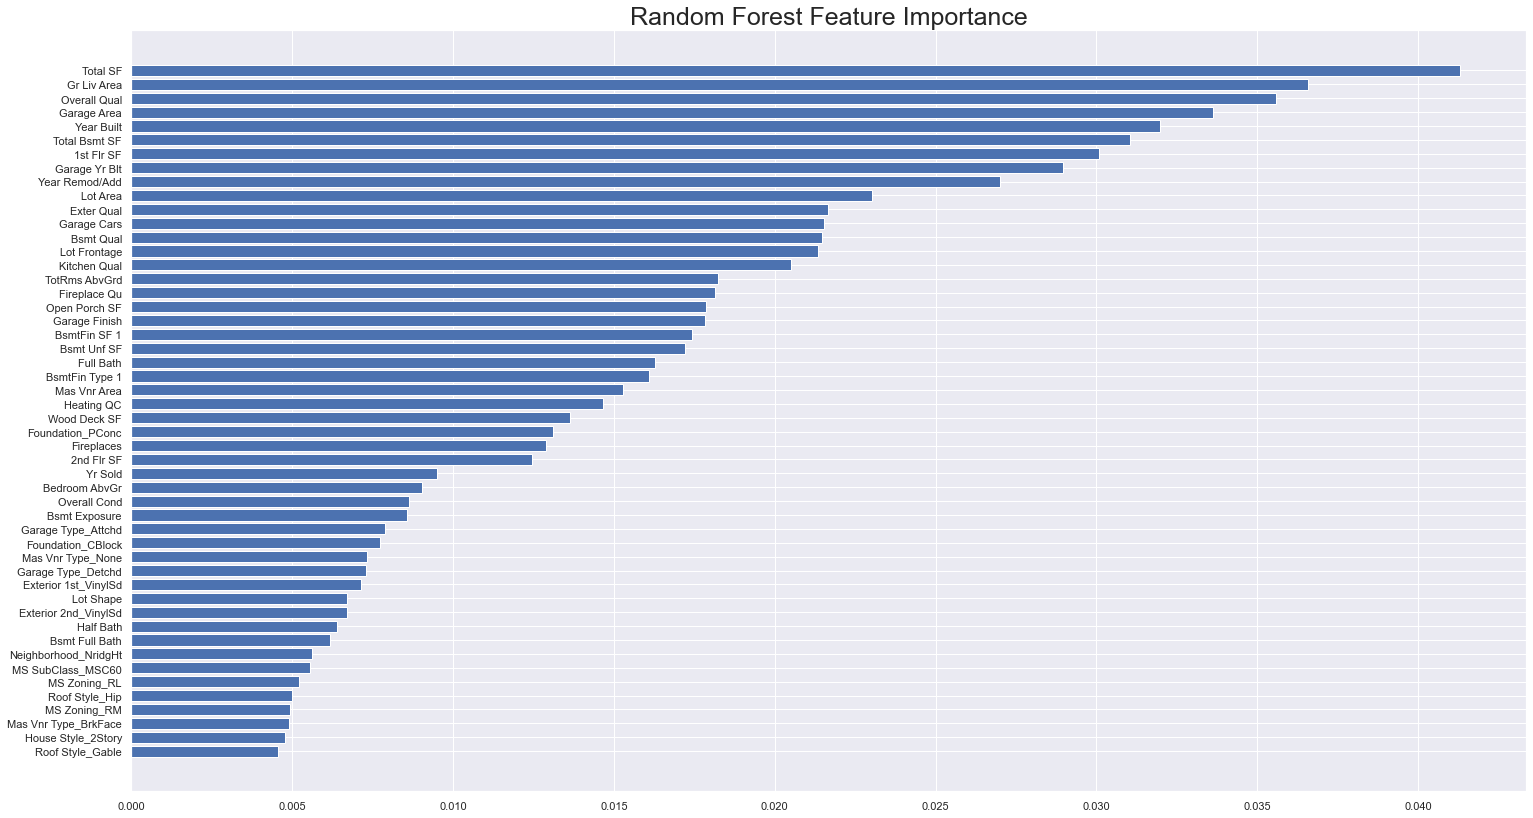

In [106]:
f, ax = plt.subplots(figsize=(25,14))
plt.title('Random Forest Feature Importance', fontsize=25)
plt.barh(range(X_select.shape[1]), importances[sorted_indicies][:importantFeatureCount])
plt.yticks(range(X_select.shape[1]), X_train.columns[sorted_indicies][:importantFeatureCount])
plt.tight_layout
ax.invert_yaxis()
plt.show()

### Lasso Selector

For the LassoCV regressor, I set intial alpha values then test them to obtain optimal alpha scores.

In [107]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1], max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print('Best alpha: ', alpha)

Best alpha:  0.0006


In [108]:
lasso_A = LassoCV(alphas = [alpha*0.6, alpha * 0.65, alpha * 0.7, alpha * 0.75, alpha * 0.8, alpha * 0.9, alpha * 0.95, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], max_iter=50000, cv = 10)

I then take my improved model and use it with SelectFromModel.  The key hyperparameter here is the threshold value which represents the cut off in terms of significant features.  At a high level such as 0.25, the lasso model returns zero features.  In order to tune the threshold parameter, I implemented a while loop that progressively lowered the value until 61 features were obtained.

In [109]:
lassofeatSelect2 = SelectFromModel(lasso_A, threshold=0.25)
lassofeatSelect2.fit(X_train,y_train)
n_features = lassofeatSelect2.transform(X_train).shape[1]
while n_features < 61:
    lassofeatSelect2.threshold -=0.001
    X_transform = lassofeatSelect2.transform(X_train)
    n_features = X_transform.shape[1]
print('Number of features:', n_features, 'n\threshold: ', lassofeatSelect2.threshold)
select_feat_lasso = X_train.columns[(lassofeatSelect2.get_support())]

Number of features: 61 n	hreshold:  0.004999999999999785


Here is the list of the top coefficients.

In [110]:
coeffs = pd.Series(lassofeatSelect2.estimator_.coef_, index=X_train.columns)
key_coeffs = pd.concat([coeffs.sort_values().head(20), coeffs.sort_values().tail(41)])
key_coeffs

Sale Condition_Abnorml   -0.06635
Condition 1_Artery       -0.04179
MS Zoning_RM             -0.03163
Neighborhood_Mitchel     -0.03056
Neighborhood_CollgCr     -0.02141
Neighborhood_SawyerW     -0.01904
Sale Condition_Family    -0.01709
Exterior 2nd_Plywood     -0.01690
Neighborhood_NWAmes      -0.01633
Neighborhood_Edwards     -0.01416
Kitchen AbvGr            -0.01032
Bsmt Unf SF              -0.00947
Central Air_N            -0.00945
MS SubClass_MSC60        -0.00927
Garage Type_CarPort      -0.00730
Lot Config_FR2           -0.00659
Bsmt Cond                -0.00621
Bedroom AbvGr            -0.00619
Total Bsmt SF            -0.00510
Mo Sold_Mar              -0.00509
Paved Drive               0.00490
Garage Yr Blt             0.00608
Mas Vnr Type_Stone        0.00657
BsmtFin Type 1            0.00688
Full Bath                 0.00776
Mo Sold_Jul               0.00790
MS SubClass_MSC20         0.00881
Exter Qual                0.00919
Garage Cars               0.00946
Screen Porch  

The contrast between the variables selected by the Random Forest selector and the Lasso selector is very interesting.  

The Random Forest selector tended to pick mainly numeric(nonObj) variables and the most important of these tend to be somewhat similar to what we might expect based on correlations with Sale Price.

While the Lasso Selector did choose variables such as Total SF and Overall Quality, it also chose a large number of categorical(obj) variables.  Some of these were judged to be very important such as Neighborhood_Crawford, Exterior 1st_BrkFace, and Sale Condition Abnormal.  I found it particularly interesting that Neighborhoods assumed such an increased importance as this group of features had been ignored by the Random Forest Selector.  

I believe this points to the Random Forest selector favoring numeric variables with a high level of cardinality.

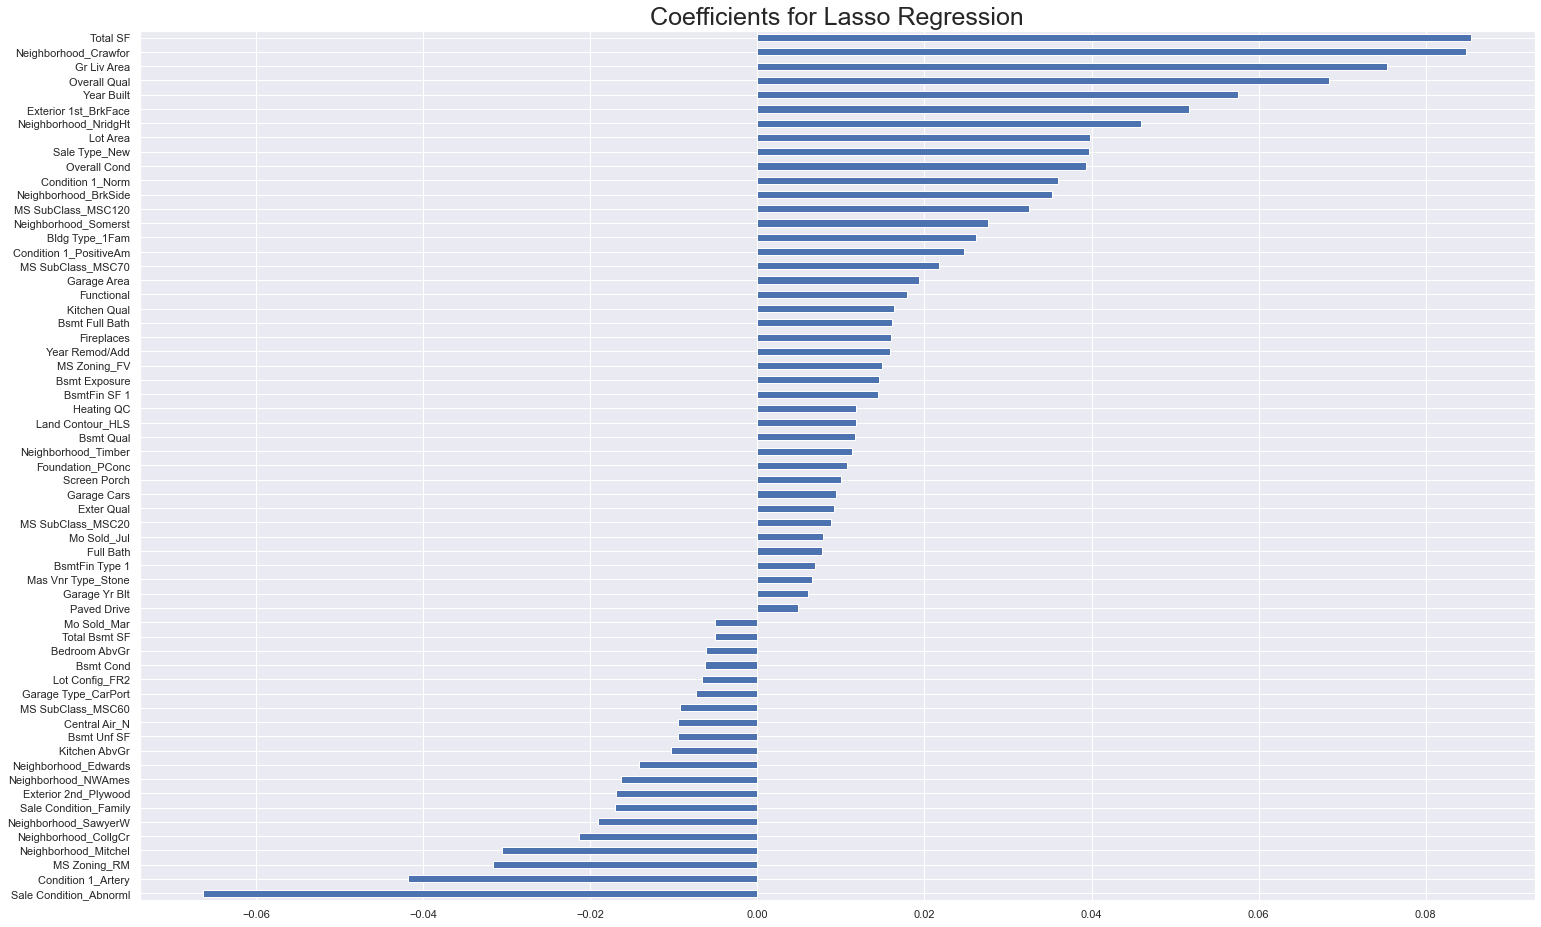

In [111]:
coeffs = pd.Series(lassofeatSelect2.estimator_.coef_, index=X_train.columns)
key_coeffs = pd.concat([coeffs.sort_values().head(20), coeffs.sort_values().tail(41)])

f, ax = plt.subplots(figsize = (25,16))
key_coeffs.plot(kind='barh')
plt.title('Coefficients for Lasso Regression', fontsize=25)
plt.show()

Main Feature Selection

Here I set up my main feature selection which includes 40 variables.  The commented out lists of features represent alternative selections of features that I had tried earlier.

In [112]:
# CombFeat = ['Total SF', 'Overall Qual', 'Year Built', 'Garage Area', 'Year Remod/Add', 'Bsmt Qual', 'Lot Area', 'Heating QC', 'Overall Cond', 'Kitchen Qual', 'Exter Qual', 'Mas Vnr Area', 'Full Bath', 'Garage Finish', 'Sale Condition_Abnorml', 'Neighborhood_Crawfor', 'Exterior 1st_BrkFace', 'Sale Condition_Family', 'Sale Type_New', 'Exterior 1st_AsbShng', 'Neighborhood_BrkSide', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Central Air_N', 'Bsmt Exposure_3', 'Condition 1_PosN', 'MS Zoning_FV', 'Condition 1_Norm', 'MS Zoning_RL', 'Functional', 'Neighborhood_StoneBr', 'MS Zoning_C (all)', 'Condition 1_Artery', 'BsmtFin SF 1', 'Mas Vnr Type_Stone','Neighborhood_SawyerW', 'Neighborhood_Gilbert', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR']

# Feat_Select_N = ['Total SF', 'Overall Qual', 'Year Built', 'Garage Area', 'Year Remod/Add', 'Bsmt Qual', 'Lot Area', 'Heating QC', 'Overall Cond', 'Kitchen Qual', 'Exter Qual', 'BsmtFin SF 1','Mas Vnr Area', 'Full Bath', 'Garage Finish', 'Neighborhood_NAmes', 'Neighborhood_Edwards', 'Neighborhood_CollgCr', 'Neighborhood_Gilbert', 'Neighborhood_OldTown', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_Sawyer', 'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_SawyerW', 'Neighborhood_Crawfor', 'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'Neighborhood_Timber','Foundation_PConc','Foundation_CBlock','Sale Condition_Abnorml', 'Sale Condition_Family', 'Sale Type_New', 'Central Air_N', 'Exterior 1st_BrkFace', 'Exterior 1st_AsbShng', 'Condition 1_Positive']


Feat_Select = ['Total SF', 'Overall Qual', 'Year Built', 'Garage Area', 'Year Remod/Add', 'Bsmt Qual', 'Lot Area', 'Heating QC', 'Overall Cond', 'Kitchen Qual', 'Exter Qual', 'BsmtFin SF 1','Mas Vnr Area', 'Full Bath', 'Garage Finish', 'Neighborhood_NAmes', 'Neighborhood_Edwards', 'Neighborhood_CollgCr', 'Neighborhood_Gilbert', 'Neighborhood_OldTown', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_Sawyer', 'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_SawyerW', 'Neighborhood_Crawfor', 'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'Neighborhood_Timber','Foundation_PConc','Foundation_CBlock', 'Foundation_Other', 'Sale Condition_Abnorml', 'Sale Condition_Family', 'Sale Type_New', 'Central Air_N', 'Exterior 1st_BrkFace', 'Exterior 1st_AsbShng', 'Condition 1_PositiveAm' ]

In [113]:
len(Feat_Select)

40

## 5. Preliminary Regression Models

In this section I create a series of basic multiple regression models with different selections of features.

### Create K-Fold CV Scorers

Before running the preliminary models I set up my K-Fold Cross Validation Scoring Metrics (Root Mean Squared Error, Mean Absolute Error,Adjusted R2).

In [114]:
scorer_rmse = make_scorer(mean_squared_error, greater_is_better=False)
scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)

def rmse_cv_train(model, X_train,cv=10, nj=-1, pred=24):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer_rmse, cv=cv, pre_dispatch=pred, n_jobs=nj))
    return(rmse)
def rmse_cv_test(model, X_test,cv=10, nj=-1, pred=24):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer_rmse, cv=cv, pre_dispatch=pred, n_jobs=nj))
    return(rmse)

def mae_cv_train(model, X_train, cv=10, nj=-1, pred=24):
    mae = -cross_val_score(model, X_train, y_train, scoring = scorer_mae, cv=cv, pre_dispatch=pred, n_jobs=nj)
    return(mae)
def mae_cv_test(model, X_test, cv=10, nj=-1, pred=24):
    mae=-cross_val_score(model, X_test, y_test, scoring= scorer_mae, cv =cv, pre_dispatch=pred, n_jobs=nj)
    return(mae)

def r2adj_cv_train(model,X_train, cv=10, nj=-1, pred=24):
    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, pre_dispatch=pred, n_jobs=nj)
    adj_r2 = 1-(1-r2) * (len(y_train)-1)/len(y_train)
    return adj_r2

def r2adj_cv_test(model,X_test, cv=10, nj=-1, pred=24):
    r2 = cross_val_score(model, X_test, y_test, scoring='r2', cv=cv, pre_dispatch=pred, n_jobs=nj)
    adj_r2 = 1-(1-r2) * (len(y_test)-1)/len(y_test)
    return adj_r2

### i. Multiple Linear Regression Model Using All Features

Originally, I had intended to include a Multiple Linear Regression model that included all 81 features.  This though did not work at all and resulted in a broken model.  While the RSME for the test data was fairly normal, the RSME for the test data ballooned .  The R2 for the training data was negative which indicates that the model is substantially worse than the mean value of Sale Price as a predictor.

In [115]:
lr_all = LinearRegression()
lr_all.fit(X_train, y_train)

LinearRegression()

In [116]:
rmse_cv_tr = rmse_cv_train(lr_all, X_train).mean()
rmse_cv_tst = rmse_cv_test(lr_all, X_test).mean()
mae_cv_tr = mae_cv_train(lr_all, X_train).mean()
mae_cv_tst = mae_cv_test(lr_all, X_test).mean()
r2adj_cv_tr = r2adj_cv_train(lr_all, X_train).mean()
r2adj_cv_tst = r2adj_cv_test(lr_all, X_test).mean()


In [117]:
pre_results = pd.DataFrame({'Linear Regression':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst}})
pre_results

Linear Regression
AdjR2 CV Test  -1126930666536769945600.00000
AdjR2 CV Train    -4758674034797168640.00000
MAE CV Test                  658335239.48019
MAE CV Train                  21855952.03904
RMSE CV Test                5750750202.38194
RMSE CV Train                300810559.93264

In [118]:
y_train_pred = lr_all.predict(X_train)
y_test_pred = lr_all.predict(X_test)

Extremely strange residuals plot and fitted-line chart.

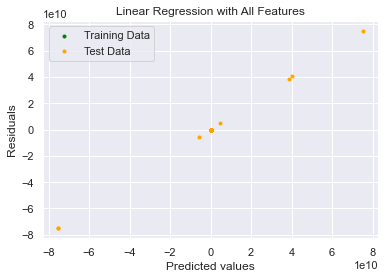

In [119]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Linear Regression with All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10.5, xmax=13.5, color='purple')
plt.show()

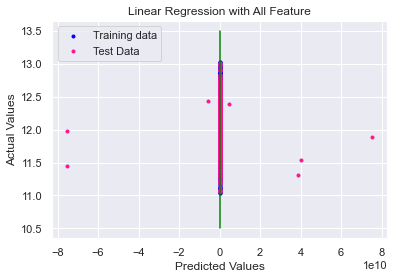

In [120]:
plt.scatter(y_train_pred, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_test_pred, y_test, c = 'deeppink', marker='.', label = 'Test Data')
plt.title('Linear Regression with All Feature')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

### ii. Multiple Linear Regression Model with Basic Feature (Highest Correlations with SalePrice)

As an alternative for my base linear model, I took the top variables correlated with Sale Price minus several variables that had a high level of collinearity.  This left me with 16 variables for the base model.

Overall, the base model performed fairly well.

In [121]:
lr_basic = LinearRegression()
lr_basic.fit(X_train[basicFeatures], y_train)

LinearRegression()

In [122]:
rmse_cv_tr = rmse_cv_train(lr_basic, X_train[basicFeatures]).mean()
rmse_cv_tst = rmse_cv_test(lr_basic, X_test[basicFeatures]).mean()
mae_cv_tr = mae_cv_train(lr_basic, X_train[basicFeatures]).mean()
mae_cv_tst = mae_cv_test(lr_basic, X_test[basicFeatures]).mean()
r2adj_cv_tr = r2adj_cv_train(lr_basic, X_train[basicFeatures]).mean()
r2adj_cv_tst = r2adj_cv_test(lr_basic, X_test[basicFeatures]).mean()


In [123]:
basic_results = pd.DataFrame({'LR BasicFeatures':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst}})
basic_results

LR BasicFeatures
AdjR2 CV Test            0.88048
AdjR2 CV Train           0.88951
MAE CV Test              0.08844
MAE CV Train             0.09001
RMSE CV Test             0.11922
RMSE CV Train            0.12347

In [124]:
pre_results = pd.concat([pre_results, basic_results], axis=1)

In [125]:
y_train_pred_basic = lr_basic.predict(X_train[basicFeatures])
y_test_pred_basic = lr_basic.predict(X_test[basicFeatures])

We can see that the residuals are fairly tightly packed around the mean and there is no discernable pattern.

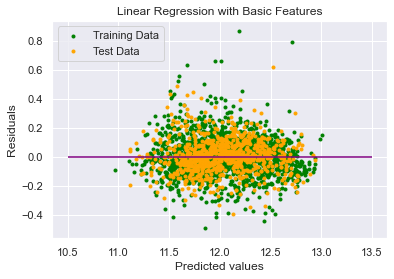

In [126]:
plt.scatter(y_train_pred_basic, y_train_pred_basic - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_test_pred_basic, y_test_pred_basic - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Linear Regression with Basic Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10.5, xmax=13.5, color='purple')
plt.show()

Below we can see that the model works fairly well.

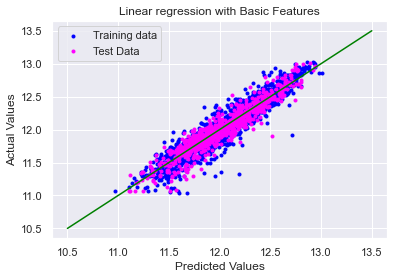

In [127]:
plt.scatter(y_train_pred_basic, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_test_pred_basic, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Linear regression with Basic Features')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

### iii. Multiple Linear Regression Model with Random Forest Feature Selection

The multiple regression model with Random Forest selected variables does perform better pushing the RSME on the test data to 0.1156826.  Of course, it includes a far larger number of features(71).  Again the residuals are tighly grouped around the mean error.

In [128]:
lr_rfSelect = LinearRegression()
lr_rfSelect.fit(X_train[select_feat_rf], y_train)

LinearRegression()

In [129]:
rmse_cv_tr = rmse_cv_train(lr_rfSelect, X_train[select_feat_rf]).mean()
rmse_cv_tst = rmse_cv_test(lr_rfSelect, X_test[select_feat_rf]).mean()
mae_cv_tr = mae_cv_train(lr_rfSelect, X_train[select_feat_rf]).mean()
mae_cv_tst = mae_cv_test(lr_rfSelect, X_test[select_feat_rf]).mean()
r2adj_cv_tr = r2adj_cv_train(lr_rfSelect, X_train[select_feat_rf]).mean()
r2adj_cv_tst = r2adj_cv_test(lr_rfSelect, X_test[select_feat_rf]).mean()

In [130]:
results_rffeat = pd.DataFrame({'LR RForestFeat Select':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst}})
results_rffeat

LR RForestFeat Select
AdjR2 CV Test                 0.90745
AdjR2 CV Train                0.90728
MAE CV Test                   0.07883
MAE CV Train                  0.08188
RMSE CV Test                  0.10443
RMSE CV Train                 0.11277

In [131]:
pre_results = pd.concat([pre_results, results_rffeat], axis=1)

In [132]:
y_train_rfF = lr_rfSelect.predict(X_train[select_feat_rf])
y_test_rfF = lr_rfSelect.predict(X_test[select_feat_rf])

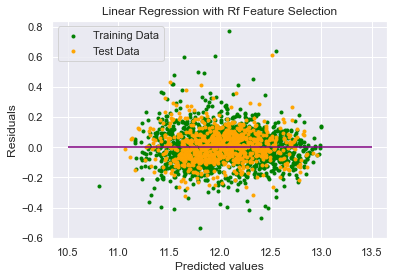

In [133]:
plt.scatter(y_train_rfF, y_train_rfF - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_test_rfF, y_test_rfF - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Linear Regression with Rf Feature Selection')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10.5, xmax=13.5, color='purple')
plt.show()

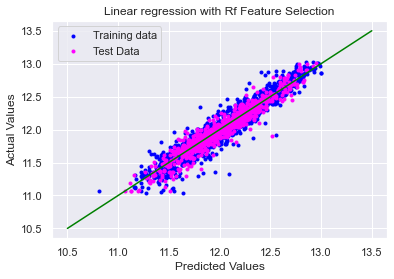

In [134]:
plt.scatter(y_train_rfF, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_test_rfF, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Linear regression with Rf Feature Selection')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

### iv. Multiple Linear Regression Model with Lasso Regression Feature Selection

The last of the preliminary models creates a multiple regression model using the features picked by the Lasso selector.  This set of features gives us the best results thus far.

In [135]:
lr_lasSelect = LinearRegression()
lr_lasSelect.fit(X_train[select_feat_lasso], y_train)


LinearRegression()

In [136]:
rmse_cv_tr = rmse_cv_train(lr_lasSelect, X_train[select_feat_lasso]).mean()
rmse_cv_tst = rmse_cv_test(lr_lasSelect, X_test[select_feat_lasso]).mean()
mae_cv_tr = mae_cv_train(lr_lasSelect, X_train[select_feat_lasso]).mean()
mae_cv_tst = mae_cv_test(lr_lasSelect, X_test[select_feat_lasso]).mean()
r2adj_cv_tr = r2adj_cv_train(lr_lasSelect, X_train[select_feat_lasso]).mean()
r2adj_cv_tst = r2adj_cv_test(lr_lasSelect, X_test[select_feat_lasso]).mean()

In [137]:
results_lassfeat = pd.DataFrame({'LR LassoFeat Select':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst}})
results_lassfeat

LR LassoFeat Select
AdjR2 CV Test               0.92498
AdjR2 CV Train              0.92647
MAE CV Test                 0.06953
MAE CV Train                0.07184
RMSE CV Test                0.09428
RMSE CV Train               0.10034

In [138]:
pre_results = pd.concat([pre_results, results_lassfeat], axis=1)

In [139]:
y_train_lasF = lr_lasSelect.predict(X_train[select_feat_lasso])
y_test_lasF = lr_lasSelect.predict(X_test[select_feat_lasso])

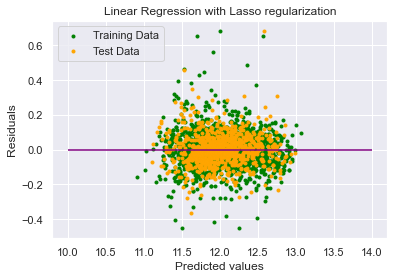

In [140]:
plt.scatter(y_train_lasF, y_train_lasF - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_test_lasF, y_test_lasF - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Linear Regression with Lasso regularization')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10, xmax=14, color='purple')
plt.show()

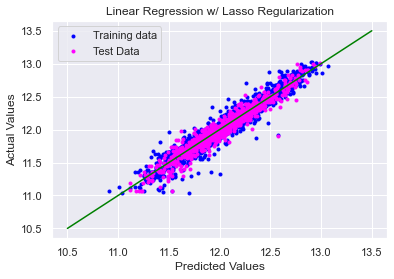

In [141]:
plt.scatter(y_train_lasF, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_test_lasF, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Linear Regression w/ Lasso Regularization')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

### Preliminary Model Results

Here then are all of the preliminary results

In [142]:
pre_results

Linear Regression  LR BasicFeatures  \
AdjR2 CV Test  -1126930666536769945600.00000           0.88048   
AdjR2 CV Train    -4758674034797168640.00000           0.88951   
MAE CV Test                  658335239.48019           0.08844   
MAE CV Train                  21855952.03904           0.09001   
RMSE CV Test                5750750202.38194           0.11922   
RMSE CV Train                300810559.93264           0.12347   

                LR RForestFeat Select  LR LassoFeat Select  
AdjR2 CV Test                 0.90745              0.92498  
AdjR2 CV Train                0.90728              0.92647  
MAE CV Test                   0.07883              0.06953  
MAE CV Train                  0.08188              0.07184  
RMSE CV Test                  0.10443              0.09428  
RMSE CV Train                 0.11277              0.10034

In [143]:
# pre_results.to_excel(f'pre_results.xlsx')

## 6. Main Models

We now move on to the main models.  For all models, I set a K number for cross validation and a variable so as to easily try different feature sets.  Note: the commented out bit is a variety of other feature selections that I tried out.

In [144]:
#all features                       X_train.columns
#Feature Select                     X_train[Feat_Select]
#Feature Select w/out FeatAdjust    X_train[Feat_Select_N]
#RF Selected Features               X_train[select_feat_rf]
#Lasso Selected Features            X_train[select_feat_lasso]
#Basic Feature                      X_train[basic_features]
featset_train = X_train[Feat_Select]
featset_test = X_test[Feat_Select]

cV=10

### i. Multiple Linear Regression

I run the model once using the timeit function which the average time of 7 runs.

In [145]:
%%capture results
%%timeit
model_lr = LinearRegression()
model_lr.fit(featset_train, y_train)

In [146]:
time = results.stdout

Next I implement the model followed by the CV scorers.

In [147]:
model_lr = LinearRegression()
model_lr.fit(featset_train, y_train)

LinearRegression()

In [148]:
rmse_cv_tr = rmse_cv_train(model_lr, featset_train, cV).mean()
rmse_cv_tst = rmse_cv_test(model_lr, featset_test, cV).mean()
mae_cv_tr = mae_cv_train(model_lr, featset_train, cV).mean()
mae_cv_tst = mae_cv_test(model_lr, featset_test, cV).mean()
r2adj_cv_tr = r2adj_cv_train(model_lr,featset_train, cv=cV).mean()
r2adj_cv_tst = r2adj_cv_test(model_lr, featset_test,cv=cV).mean()

Set up predictions for entire train and test set for purpose of charting.

In [149]:
y_train_lr = model_lr.predict(featset_train)
y_test_lr = model_lr.predict(featset_test)

We can see that the plots are very similar to the preliminary regression models.

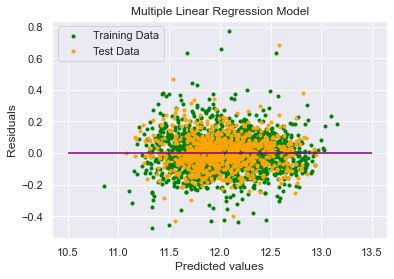

In [150]:
plt.scatter(y_train_lr, y_train_lr - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_test_lr, y_test_lr - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Multiple Linear Regression Model')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10.5, xmax=13.5, color='purple')
plt.show()

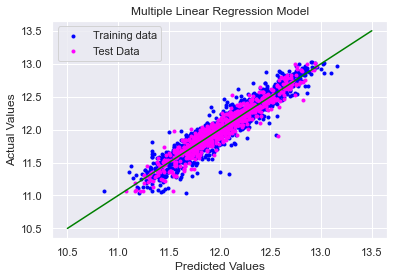

In [151]:
plt.scatter(y_train_lr, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_test_lr, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Multiple Linear Regression Model')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

The results are very impressive.  The only issue with the multiple linear regression model is that with some of the larger feature sets the model breaks (as it did with all features included)

In [152]:
result = pd.DataFrame({'Linear Regression':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst, 'Time':time}})
result

Linear Regression
AdjR2 CV Test                                             0.90451
AdjR2 CV Train                                            0.90538
MAE CV Test                                               0.08071
MAE CV Train                                              0.08315
RMSE CV Test                                              0.10596
RMSE CV Train                                             0.11384
Time            1.57 ms +- 18.7 us per loop (mean +- std. dev....

### ii. Lasso Regression

Here, I implement the Lasso Regressor.  While for other models I utilized RandomizedSearchCV in order to test different varaibles, with Lasso model I just have to test the alpha score which can simply be done with a test run of the Lasso model which itself is a cv model.

In [153]:
#Linear Regression with Lasso regularization
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1], max_iter = 50000, cv = 10)
lasso.fit(featset_train, y_train)
alpha = lasso.alpha_
print('Best alpha: ', alpha)

Best alpha:  0.0001


I check the time it takes to run the Lasso model.

In [154]:
%%capture results
%%timeit
lasso_A = LassoCV(alphas = [alpha*0.6, alpha * 0.65, alpha * 0.7, alpha * 0.75, alpha * 0.8, alpha * 0.9, alpha * 0.95, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], max_iter=50000, cv = 10)
lasso_A.fit(featset_train, y_train)

In [155]:
time=results.stdout

Run the Lasso model followed by CV scorers

In [156]:
lasso_A = LassoCV(alphas = [alpha*0.6, alpha * 0.65, alpha * 0.7, alpha * 0.75, alpha * 0.8, alpha * 0.9, alpha * 0.95, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], max_iter=50000, cv = 10)
lasso_A.fit(featset_train, y_train)
print('Best alpha: ', alpha)

Best alpha:  0.0001


In [157]:
rmse_cv_tr = rmse_cv_train(lasso_A, featset_train, cV).mean()
rmse_cv_tst = rmse_cv_test(lasso_A, featset_test, cV).mean()
mae_cv_tr = mae_cv_train(lasso_A, featset_train, cV).mean()
mae_cv_tst = mae_cv_test(lasso_A, featset_test, cV).mean()
r2adj_cv_tr = r2adj_cv_train(lasso_A, featset_train, cv=cV).mean()
r2adj_cv_tst = r2adj_cv_test(lasso_A, featset_test,cv=cV).mean()

In [158]:
y_train_las = lasso_A.predict(featset_train)
y_test_las = lasso_A.predict(featset_test)

The residuals plot looks fine.

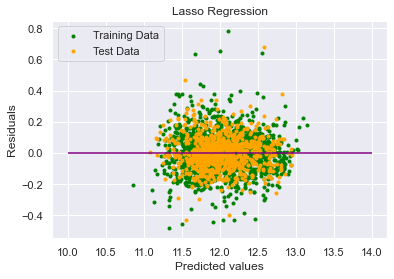

In [159]:
plt.scatter(y_train_las, y_train_las - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_test_las, y_test_las - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Lasso Regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10, xmax=14, color='purple')
plt.show()

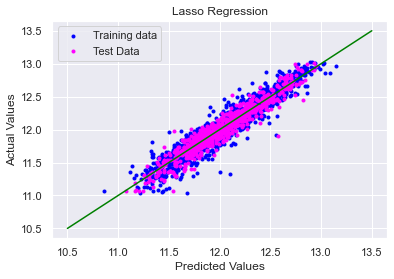

In [160]:
plt.scatter(y_train_las, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_test_las, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Lasso Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

I thought I would check to see what features the model was using.

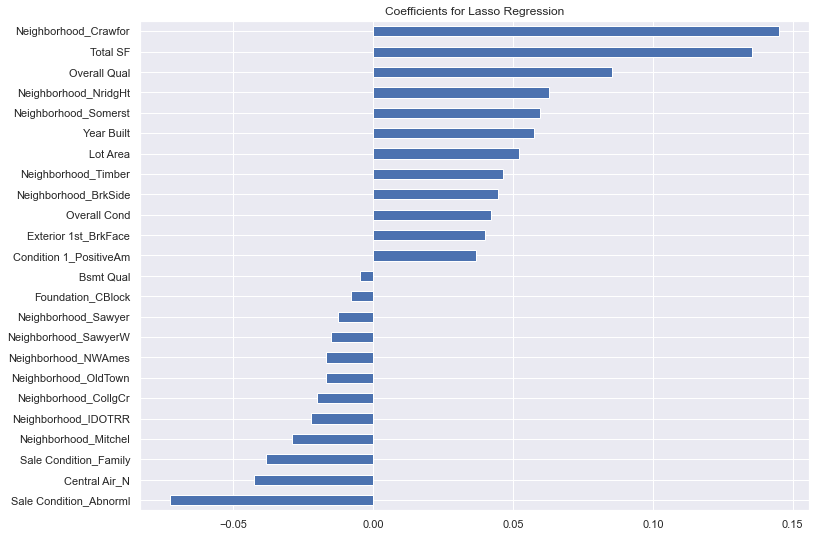

In [161]:
coeffs = pd.Series(lasso_A.coef_, index=featset_train.columns)
plt.figure(figsize=(12,9))
key_coeffs = pd.concat([coeffs.sort_values().head(12), coeffs.sort_values().tail(12)])
key_coeffs.plot(kind='barh')

plt.title('Coefficients for Lasso Regression')
plt.show()

The results are very good though just a little bit better than plain Multiple Linear Regression.

In [162]:
results_lasso = pd.DataFrame({'Lasso Regression':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst, 'Time':time}})
results_lasso

Lasso Regression
AdjR2 CV Test                                             0.90508
AdjR2 CV Train                                            0.90540
MAE CV Test                                               0.08035
MAE CV Train                                              0.08304
RMSE CV Test                                              0.10559
RMSE CV Train                                             0.11382
Time            24.8 ms +- 1.58 ms per loop (mean +- std. dev....

In [163]:
result = pd.concat([result, results_lasso], axis=1)

### iii. Decision Tree Regressor

Starting with the Decision Tree I use RandomizedSearchCV to narrow down the optimal parameters after a bit of trial and error.

In [164]:

opti_params = {'criterion':['squared_error'],
        'splitter':['best'],
        'max_depth': [None,5,50,65,75,100],
        'max_features':['auto', 'sqrt','log2'],
        'max_leaf_nodes':[None,150,175,250,500,750],
        'min_samples_leaf':[5,6,7,8,9,10],
        'min_weight_fraction_leaf':[0.0],
        }

In [165]:
opti_model_decTree = DecisionTreeRegressor(random_state=0)
opti_decTree = RandomizedSearchCV(estimator=opti_model_decTree, param_distributions=opti_params, scoring='neg_mean_squared_error', cv=5, n_iter=100, verbose=1, error_score='raise')
opti_decTree.fit(featset_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=DecisionTreeRegressor(random_state=0), n_iter=100,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [None, 5, 50, 65, 75, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [None, 150, 175, 250,
                                                           500, 750],
                                        'min_samples_leaf': [5, 6, 7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.0],
                                        'splitter': ['best']},
                   scoring='neg_mean_squared_error', verbose=1)

In [166]:
print('Best Params: ', opti_decTree.best_params_)
print('Lowest RMSE: ', np.sqrt(-opti_decTree.best_score_))

Best Params:  {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_leaf': 10, 'max_leaf_nodes': 500, 'max_features': 'auto', 'max_depth': 75, 'criterion': 'squared_error'}
Lowest RMSE:  0.15870239514520515


I then visualize the loss function to see how adding levels to the tree depth works in relation to MSE.

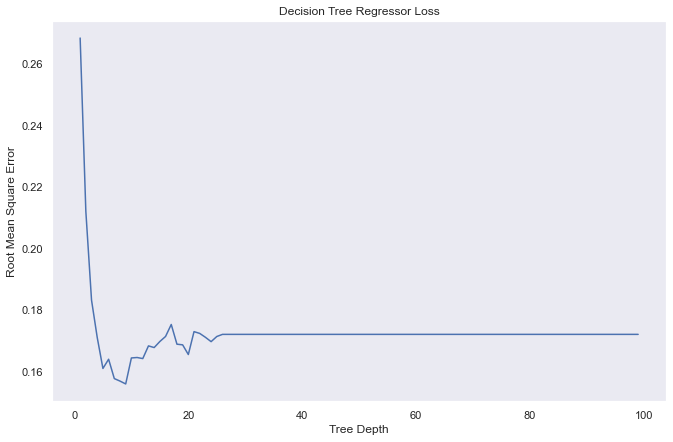

In [167]:
rmse = []
for depth in range(1, 100):
    tree_reg=DecisionTreeRegressor(random_state=0, max_depth=depth)
    tree_reg.fit(featset_train, y_train)
    tree_predictions=tree_reg.predict(featset_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, tree_predictions)))
    
tree_depths = [depth for depth in range(1,100)]

plt.figure(figsize=(11,7))
plt.title('Decision Tree Regressor Loss')
plt.grid()
plt.plot(tree_depths,rmse)
plt.xlabel('Tree Depth')
plt.ylabel('Root Mean Square Error')
plt.show()

After the preliminary test is over, I time the final model and then implement it again for the various cross validation scorers.

In [168]:
%%capture results
%%timeit
model_decTree = DecisionTreeRegressor(random_state=0, min_samples_leaf=5, max_leaf_nodes=175, max_features='auto', max_depth=75, criterion='squared_error')
model_decTree.fit(featset_train, y_train)

In [169]:
time=results.stdout

In [170]:
model_decTree = DecisionTreeRegressor(random_state=0, max_depth=8, min_samples_leaf=10,max_leaf_nodes=500,criterion='squared_error')
model_decTree.fit(featset_train, y_train)

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=500, min_samples_leaf=10,
                      random_state=0)

In [171]:
rmse_cv_tr = rmse_cv_train(model_decTree, featset_train, cV).mean()
rmse_cv_tst = rmse_cv_test(model_decTree, featset_test, cV).mean()
mae_cv_tr = mae_cv_train(model_decTree, featset_train, cV).mean()
mae_cv_tst = mae_cv_test(model_decTree, featset_test, cV).mean()
r2adj_cv_tr = r2adj_cv_train(model_decTree, featset_train, cv=cV).mean()
r2adj_cv_tst = r2adj_cv_test(model_decTree, featset_test,cv=cV).mean()

Here I visualize the entire 8 levels of the regression tree.  The resulting chart is really big and would be difficult to show in a report or presentation so I created a representation of the first 3 levels to give an idea of how the tree model proceeded.

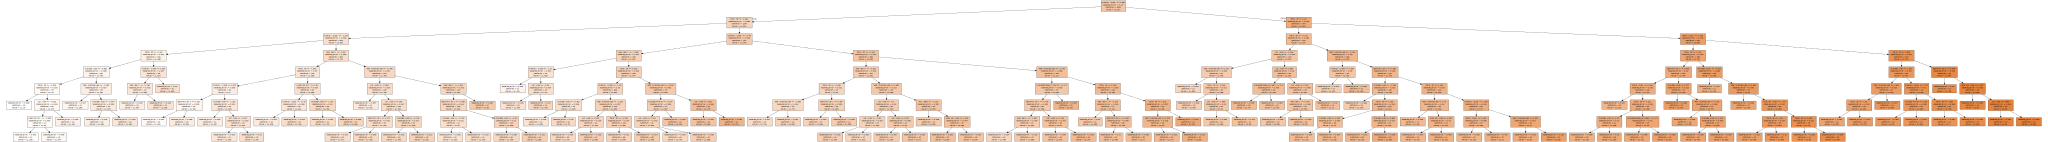

In [172]:
dot_data = export_graphviz(model_decTree, out_file=None, feature_names=featset_train.columns, filled=True)#, max_depth=3)
vizTree = graphviz.Source(dot_data, format='png')
vizTree
#vizTree.render()

In [173]:
y_prTrain_dt = model_decTree.predict(featset_train)
y_prTest_dt = model_decTree.predict(featset_test)

The residuals seem a bit more spread out but I think it is still okay.

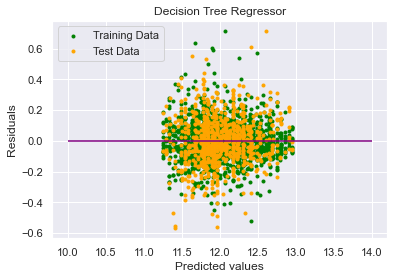

In [174]:
plt.scatter(y_prTrain_dt, y_prTrain_dt - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_prTest_dt, y_prTest_dt - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Decision Tree Regressor')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10, xmax=14, color='purple')
plt.show()

This line chart struck me as a bit funny.  The points are all really concentrated in area but that concentration is quite fat.

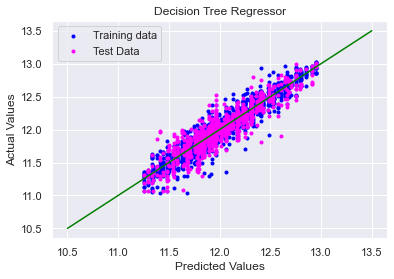

In [175]:
plt.scatter(y_prTrain_dt, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_prTest_dt, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Decision Tree Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

The results for the Regression Tree are disappointing in comparison with the other models.

In [176]:
results_decTree = pd.DataFrame({'Decision Tree':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst, 'Time':time}})
results_decTree

Decision Tree
AdjR2 CV Test                                             0.75966
AdjR2 CV Train                                            0.82707
MAE CV Test                                               0.12676
MAE CV Train                                              0.11246
RMSE CV Test                                              0.16945
RMSE CV Train                                             0.15489
Time            7.93 ms +- 98.4 us per loop (mean +- std. dev....

In [177]:
result = pd.concat([result, results_decTree], axis=1)

### iv. Random Forest Regressor

I follow much the same procedure here beginning with trying out a number of different parameters.

In [178]:
opti_params = {'criterion':['squared_error'],
        'n_estimators':[400,500,1000],
        'max_depth': [2,50,85],
        'max_features':['sqrt','auto'],
        'min_samples_split':[2,3,4,5],
        'min_samples_leaf':[1,2,3,4]
        }

In [179]:
opti_model_rf = RandomForestRegressor()
opti_rf = RandomizedSearchCV(estimator=opti_model_rf, param_distributions=opti_params, scoring='neg_mean_squared_error', cv=5, n_iter=100, verbose=1, n_jobs=-1, error_score='raise')
opti_rf.fit(featset_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [2, 50, 85],
                                        'max_features': ['sqrt', 'auto'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [400, 500, 1000]},
                   scoring='neg_mean_squared_error', verbose=1)

In [180]:
print('Best Params: ', opti_rf.best_params_)
print('Lowest RMSE: ', np.sqrt(-opti_rf.best_score_))

Best Params:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 85, 'criterion': 'squared_error'}
Lowest RMSE:  0.12271954503137808


Again I visualize how the model progresses.  Note that here I am using an Out of Bag Error rate.

In [181]:

rf_model = RandomForestRegressor(criterion='mse', random_state=0, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=50, n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)
min_estimators=100
max_estimators=1000
error_rate= {'label':[]}
for i in range(min_estimators, max_estimators+1, 5):
    rf_model.set_params(n_estimators=i)
    rf_model.fit(featset_train,y_train)
    oob_error = 1-rf_model.oob_score_
    error_rate['label'].append((i,oob_error))

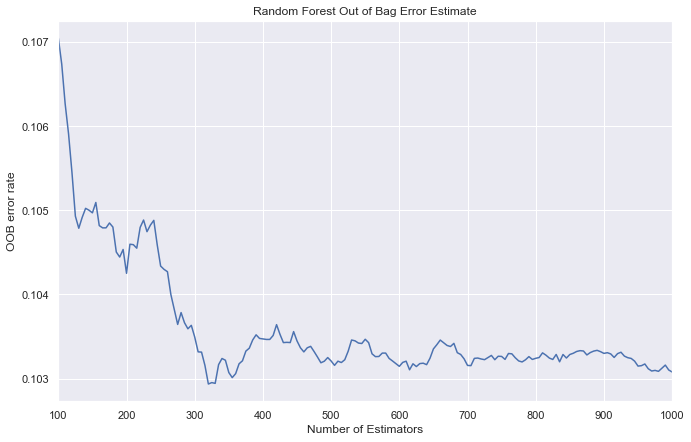

In [182]:
plt.figure(figsize=(11,7))

for label, reg_error in error_rate.items():
    xs,ys=zip(*reg_error)
    plt.plot(xs,ys,label=label)
plt.title('Random Forest Out of Bag Error Estimate')
plt.xlim(min_estimators, max_estimators)
plt.xlabel('Number of Estimators')
plt.ylabel('OOB error rate')

plt.show()

Check the time for the random forest model

In [183]:
%%capture results
%%timeit
model_rf = RandomForestRegressor(criterion='squared_error', n_estimators=315, max_depth=50, random_state=0, min_samples_split=4, min_samples_leaf=1, max_features='sqrt',  n_jobs=-1)
model_rf.fit(featset_train, y_train)

In [184]:
time= results.stdout

Next I implement the model and run the CV scorers.

In [185]:
model_rf = RandomForestRegressor(criterion='mse', n_estimators=315, max_depth=50, random_state=0, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', n_jobs=-1)
model_rf.fit(featset_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=50, max_features='sqrt',
                      n_estimators=315, n_jobs=-1, random_state=0)

In [186]:
rmse_cv_tr = rmse_cv_train(model_rf, featset_train, cV).mean()
rmse_cv_tst = rmse_cv_test(model_rf, featset_test, cV).mean()
mae_cv_tr = mae_cv_train(model_rf, featset_train, cV).mean()
mae_cv_tst = mae_cv_test(model_rf, featset_test, cV).mean()
r2adj_cv_tr = r2adj_cv_train(model_rf, featset_train, cv=cV).mean()
r2adj_cv_tst = r2adj_cv_test(model_rf, featset_test,cv=cV).mean()

Here I visualized the last of the forest's tree predictors.  This is an even bigger tree with a depth of 50.  It is quite different than the Regression Tree model which makes sense as the point of the random forest is to create a large number of different trees to capture (reduce) variation in the dataset.

In [187]:
dot_data = export_graphviz(model_rf.estimators_[314], out_file=None, feature_names=featset_train.columns, filled=True)#, max_depth=3)
vizTree = graphviz.Source(dot_data, format='png')
vizTree
#vizTree.render()

I just wanted to check to see the max depth for the tree above.

In [188]:
model_rf.estimators_[314].max_depth

50

In [189]:
y_prTrain_rf = model_rf.predict(featset_train)
y_prTest_rf = model_rf.predict(featset_test)

Again the residuals seem a little funny but I don't believe there is any clear pattern.

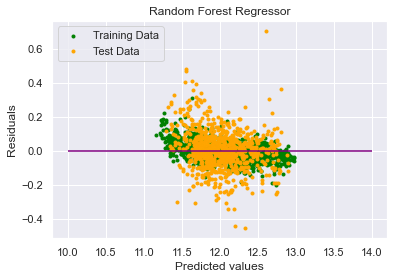

In [190]:
plt.scatter(y_prTrain_rf, y_prTrain_rf - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_prTest_rf, y_prTest_rf - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Random Forest Regressor')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10, xmax=14, color='purple')
plt.show()

The  data points are tighter for the random forest and not quite as fat.

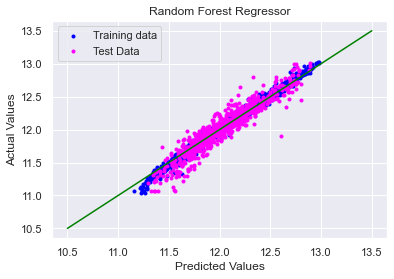

In [191]:
plt.scatter(y_prTrain_rf, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_prTest_rf, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Random Forest Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

Fairly decent results although random forest doesn't perform quite as well as plain linear regression and requires far more time.

In [192]:
results_rForest = pd.DataFrame({'Random Forest':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst, 'Time':time}})
results_rForest

Random Forest
AdjR2 CV Test                                             0.87241
AdjR2 CV Train                                            0.89348
MAE CV Test                                               0.08855
MAE CV Train                                              0.08594
RMSE CV Test                                              0.12412
RMSE CV Train                                             0.12111
Time            242 ms +- 8.09 ms per loop (mean +- std. dev. ...

In [193]:
result = pd.concat([result,results_rForest], axis=1)

### v. Gradient Boosting (XGBoost)

I decided to use XGBoost instead of the scikit-learn's gradient boosting algorithm because it apparently runs faster, is more memory efficient and offers better predictive performance.  Conveniently XGBoost does have a sklearn wrapper.

With the XGBoost, I had some trouble when I tried to chart a more developed model.  As such, I reversed my normal procedure and start by charting the model's loss function.  We can see the the rmse score declining as the model runs through its training iterations.

In [194]:
test_model = xgb.XGBRegressor(random_state=0, n_jobs=-6)
evalset = [(featset_train,y_train), (featset_test,y_test)]
test_model.fit(featset_train, y_train, eval_metric='rmse', eval_set=evalset)
yhat=test_model.predict(featset_test)
score=mean_squared_error(y_test, yhat)
res = test_model.evals_result()


[0]	validation_0-rmse:8.07923	validation_1-rmse:8.06223
[1]	validation_0-rmse:5.66062	validation_1-rmse:5.64633
[2]	validation_0-rmse:3.96769	validation_1-rmse:3.95455
[3]	validation_0-rmse:2.78276	validation_1-rmse:2.77111
[4]	validation_0-rmse:1.95357	validation_1-rmse:1.94489
[5]	validation_0-rmse:1.37376	validation_1-rmse:1.36529
[6]	validation_0-rmse:0.96881	validation_1-rmse:0.96115
[7]	validation_0-rmse:0.68635	validation_1-rmse:0.67978
[8]	validation_0-rmse:0.48986	validation_1-rmse:0.48597
[9]	validation_0-rmse:0.35407	validation_1-rmse:0.35253
[10]	validation_0-rmse:0.26090	validation_1-rmse:0.26239
[11]	validation_0-rmse:0.19685	validation_1-rmse:0.20324
[12]	validation_0-rmse:0.15466	validation_1-rmse:0.16596
[13]	validation_0-rmse:0.12782	validation_1-rmse:0.14410
[14]	validation_0-rmse:0.11081	validation_1-rmse:0.13257
[15]	validation_0-rmse:0.10070	validation_1-rmse:0.12606
[16]	validation_0-rmse:0.09279	validation_1-rmse:0.12310
[17]	validation_0-rmse:0.08685	validation

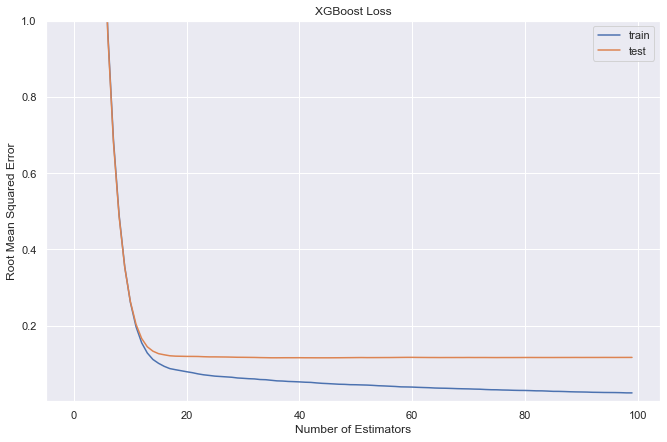

In [195]:
plt.figure(figsize=(11,7))
plt.title('XGBoost Loss')
plt.plot(res['validation_0']['rmse'], label='train')
plt.plot(res['validation_1']['rmse'], label='test')
plt.ylim(0.001, 1)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Estimators')
plt.legend()
plt.show()

In [196]:
opti_params = {'n_estimators':[20,50,100],
        'max_depth': [2,3,5,6,7,10,15],
        'learning_rate':[0.1,0.15,0.300],
        'min_child_weight':[4,5,6,7,8,9],
        'reg_alpha':[0.1, 0.01, 0.001,0.0001],
        'colsample_bytree=1':[2]
        }

In [197]:
opti_model_xgb = xgb.XGBRegressor(random_state=42)
opti_xgb = RandomizedSearchCV(estimator=opti_model_xgb, param_distributions=opti_params, scoring='neg_mean_squared_error', cv=5, n_iter=100, n_jobs=-1)
opti_xgb.fit(featset_train, y_train, early_stopping_rounds=5, eval_set=[(featset_test, y_test)])

[19:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytree=1" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:10.36208
[1]	validation_0-rmse:9.32666
[2]	validation_0-rmse:8.39505
[3]	validation_0-rmse:7.55590
[4]	validation_0-rmse:6.80103
[5]	validation_0-rmse:6.12128
[6]	validation_0-rmse:5.51034
[7]	validation_0-rmse:4.95932
[8]	validation_0-rmse:4.46384
[9]	validation_0-rmse:4.01845
[10]	validation_0-rmse:3.61764
[11]	validation_0-rmse:3.25663
[12]	validation_0-rmse:2.93153
[13]	validation_0-rmse:2.63981
[14]	validation_0-rmse:2.37688
[15]	validation_0-rmse:2.14036
[16]	validation_0-rmse:1.92731
[17]	validation_0-rmse:1.73574
[18]	validation_0-rmse:1

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate

In [198]:
print('Best Params: ', opti_xgb.best_params_)
print('Lowest RMSE: ', np.sqrt(-opti_xgb.best_score_))

Best Params:  {'reg_alpha': 0.0001, 'n_estimators': 100, 'min_child_weight': 8, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree=1': 2}
Lowest RMSE:  0.11557831728945535


I decided that I would go with a larger n estimators size than the loss function suggested.  In trials the results were a bit better.

In [199]:
%%capture results
%%timeit

model_xgb = xgb.XGBRegressor(n_estimators=100, min_child_weight=8, max_depth=8, colsample_bytree=1, learning_rate=0.15, reg_alpha=0.0001, n_jobs=-1, random_state=0)
model_xgb.fit(featset_train,y_train)

In [200]:
time = results.stdout

After the timing the model, I implement it again along the CV scorers.

In [201]:
model_xgb = model_xgb = xgb.XGBRegressor(n_estimators=100, min_child_weight=8, max_depth=5, colsample_bytree= 1, learning_rate=0.15, reg_alpha=0.0001, n_jobs=-1, random_state=0)
model_xgb.fit(featset_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=5, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.0001, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [202]:
rmse_cv_tr = rmse_cv_train(model_xgb, featset_train, cV).mean()
rmse_cv_tst = rmse_cv_test(model_xgb, featset_test, cV).mean()
mae_cv_tr = mae_cv_train(model_xgb, featset_train, cV).mean()
mae_cv_tst = mae_cv_test(model_xgb, featset_test, cV).mean()
r2adj_cv_tr = r2adj_cv_train(model_xgb, featset_train, cv=cV).mean()
r2adj_cv_tst = r2adj_cv_test(model_xgb, featset_test,cv=cV).mean()

In [203]:
y_prTrain_xgb = model_xgb.predict(featset_train)
y_prTest_xgb = model_xgb.predict(featset_test)

The residuals plot looks better than the one for random forest.

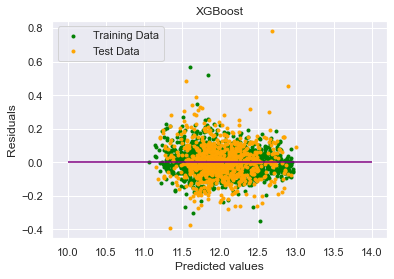

In [204]:
plt.scatter(y_prTrain_xgb, y_prTrain_xgb - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_prTest_xgb, y_prTest_xgb - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('XGBoost')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10, xmax=14, color='purple')
plt.show()

Appearance wise this looks pretty similar to the random forest fitted line chart.

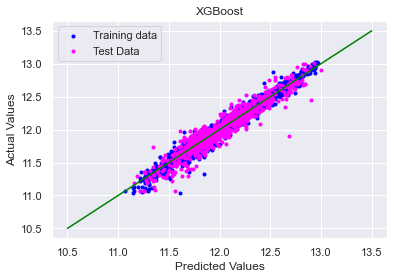

In [205]:
plt.scatter(y_prTrain_xgb, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_prTest_xgb, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('XGBoost')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

Quite good results that are right up there with Lasso and Multiple Regression in terms of effectiveness.  Of course, the model does take a bit more time but is still quite efficient for an ensemble model.

In [206]:
results_xgboost = pd.DataFrame({'XGBoost':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst, 'Time':time}})
results_xgboost

XGBoost
AdjR2 CV Test                                             0.89248
AdjR2 CV Train                                            0.90865
MAE CV Test                                               0.08368
MAE CV Train                                              0.08027
RMSE CV Test                                              0.11206
RMSE CV Train                                             0.11170
Time            113 ms +- 3.37 ms per loop (mean +- std. dev. ...

In [207]:
result = pd.concat([result, results_xgboost], axis=1)

### vi. Artificial Neural Network Perceptron (Keras)

In [208]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

I utilize the GPU in order to speed up caculations.

In [209]:
tf.device('/GPU:0')

Here I define a basic model and then experiment with RandomizedSearchCV to find optimal parameters.  Given the time required to run the models this took a while.

In [210]:
def base_model(neurons=1):
    base_model = Sequential()
    base_model.add(Dense(neurons, input_dim=featset_train.shape[1], kernel_initializer='normal', activation='relu'))
    #base_model.add(Dense(neurons, activation='relu'))
    base_model.add(Dense(1, kernel_initializer='normal'))
    base_model.compile(loss='mean_squared_error', optimizer='adam')
    return base_model

Note: For most models I have left the RandomizedSearchCV code but for the neural network I commented it out as it takes so long.

In [211]:
# opti_params = {'neurons':[85],
#                 'epochs':[100,250,500],
#                 'batch_size':[25,50]}

# opti_model_ann = KerasRegressor(build_fn=base_model, verbose=0)
# opti_ann = RandomizedSearchCV(estimator=opti_model_ann, param_distributions=opti_params, pre_dispatch=1, n_jobs=-4, n_iter=100, cv=5)
# opti_ann_result = opti_ann.fit(featset_train, y_train)
# print("Best: %f using %s" % (np.sqrt(-opti_ann_result.best_score_), opti_ann_result.best_params_))
# means = np.sqrt(-opti_ann_result.cv_results_['mean_test_score'])
# #stds = opti_ann_result.cv_results_['std_test_score']
# params = opti_ann_result.cv_results_['params']
# for mean, param in zip(means,params):
#     print("%f with: %r" % (mean,param))


I was having problems with my video card still tying up all its memory after I ran a model.  This helped release the memory.

In [212]:
# tf.keras.backend.clear_session()

After trying to figure out what setting might work best, I implement my model.  While I did try a model with 2 hidden layers, the results with a single layer of 85 nodes worked the best.  Note I am using the sklearn regressor wrapper for Keras.

In [213]:
def ann_model(neurons=1):
    base_model = Sequential()
    base_model.add(Dense(85, input_dim=featset_train.shape[1], kernel_initializer='normal', activation='relu'))
    #base_model.add(Dense(neurons, activation='relu'))
    base_model.add(Dense(1, kernel_initializer='normal'))
    base_model.compile(loss='mean_squared_error', optimizer='adam')
    return base_model

In [215]:
model_ann = KerasRegressor(build_fn=ann_model, epochs = 100, batch_size=25, verbose=0)

In [216]:
history = model_ann.fit(featset_train, y_train, validation_data=(featset_test,y_test), epochs=200, batch_size=20, verbose=0)

In [217]:
print(history.history.keys())


dict_keys(['loss', 'val_loss'])


Here I chart the loss function for the ANN.  In contrast to the other models, this was not so helpful.  The chart suggests that the RMSE should decline below 0.025 for both train and test data but I could not get anywhere close to those results with my CV scorers.

Text(0.5, 0, 'epoch')

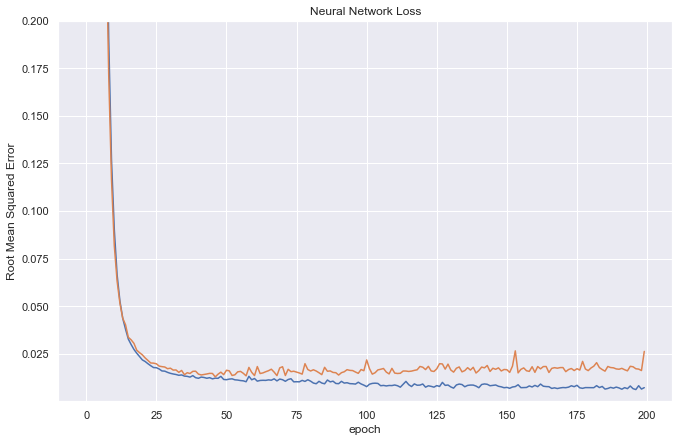

In [218]:
plt.figure(figsize=(11,7))
plt.title('Neural Network Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0.00001,0.20)
plt.title('Neural Network Loss')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('epoch')

In [ ]:
# model_ann = KerasRegressor(build_fn=ann_model, epochs = 25, batch_size=10, verbose=0)

In practive I found that a model with 100 epochs and a batch size of 25 produced the best results.

In [219]:
%%capture results
%%timeit

model_ann.fit(featset_train, y_train)

In [220]:
time=results.stdout

In [221]:
model_ann.fit(featset_train, y_train)

Here I created a very basic visualization of the ANN model.  It really doesn't tell us very much.  I need to do some future work to find better ways of representing neural network models.  I believe that Tensor Board might be the way to go but I need to do some further work to figure it out. 

In [222]:
viz_mod = Sequential([
    Dense(85, activation='relu', input_shape=(40,)),
    Dense(1)
])
visualizer(viz_mod, filename='ann_model', format='png', view=True)

In [223]:
rmse_cv_tr = rmse_cv_train(model_ann, featset_train, cV, nj=-4, pred=1).mean()
rmse_cv_tst = rmse_cv_test(model_ann, featset_test, cV, nj=-4, pred=1).mean()
mae_cv_tr = mae_cv_train(model_ann, featset_train, cV, nj=-4, pred=1).mean()
mae_cv_tst = mae_cv_test(model_ann, featset_test, cV, nj=-4, pred=1).mean()
r2adj_cv_tr = r2adj_cv_train(model_ann, featset_train, cv=cV, nj=-4, pred=1).mean()
r2adj_cv_tst = r2adj_cv_test(model_ann, featset_test,cv=cV, nj=-4, pred=1).mean()

In [224]:
y_prTrain_ann = model_ann.predict(featset_train)
y_prTest_ann = model_ann.predict(featset_test)

This residuals plot is concerning as the center of the distribution is a fair bit higher than the mean.

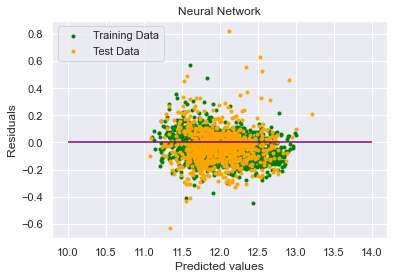

In [225]:
plt.scatter(y_prTrain_ann, y_prTrain_ann - y_train, c='green', marker='.', label= 'Training Data')
plt.scatter(y_prTest_ann, y_prTest_ann - y_test, c='orange', marker='.', label = 'Test Data')
plt.title('Neural Network')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y = 0, xmin=10, xmax=14, color='purple')
plt.show()

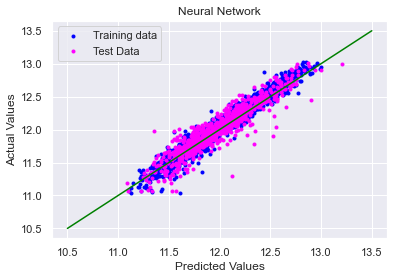

In [226]:
plt.scatter(y_prTrain_ann, y_train, c = 'blue', marker='.', label = 'Training data')
plt.scatter(y_prTest_ann, y_test, c = 'magenta', marker='.', label = 'Test Data')
plt.title('Neural Network')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend(loc = 'upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'green')
plt.show()

The results are okay.  It provides better effectiveness metrics than the regression tree.  However, it is absolutely the worst model in terms of time efficiency.

In [227]:
results_ann = pd.DataFrame({'NeuralNet':{'RMSE CV Train': rmse_cv_tr, 'RMSE CV Test': rmse_cv_tst, 'MAE CV Train': mae_cv_tr, 'MAE CV Test': mae_cv_tst, 'AdjR2 CV Train': r2adj_cv_tr, 'AdjR2 CV Test': r2adj_cv_tst, 'Time':time}})
results_ann

NeuralNet
AdjR2 CV Test                                             0.82149
AdjR2 CV Train                                            0.86703
MAE CV Test                                               0.10753
MAE CV Train                                              0.09869
RMSE CV Test                                              0.14482
RMSE CV Train                                             0.13324
Time            12.5 s +- 873 ms per loop (mean +- std. dev. o...

In [228]:
result = pd.concat([result, results_ann], axis=1)

## 7. The Final Results

Here then are the final results for all models at the particular k level set earlier.

In [229]:
result

Linear Regression  \
AdjR2 CV Test                                             0.90451   
AdjR2 CV Train                                            0.90538   
MAE CV Test                                               0.08071   
MAE CV Train                                              0.08315   
RMSE CV Test                                              0.10596   
RMSE CV Train                                             0.11384   
Time            1.57 ms +- 18.7 us per loop (mean +- std. dev....   

                                                 Lasso Regression  \
AdjR2 CV Test                                             0.90508   
AdjR2 CV Train                                            0.90540   
MAE CV Test                                               0.08035   
MAE CV Train                                              0.08304   
RMSE CV Test                                              0.10559   
RMSE CV Train                                             0.11382   
Time            24.8 ms +- 1.58 ms per loop (mean +- std. dev....   

                                                    Decision Tree  \
AdjR2 CV Test                                             0.75966   
AdjR2 CV Train                                            0.82707   
MAE CV Test                                               0.12676   
MAE CV Train                                              0.11246   
RMSE CV Test                                              0.16945   
RMSE CV Train                                             0.15489   
Time            7.93 ms +- 98.4 us per loop (mean +- std. dev....   

                                                    Random Forest  \
AdjR2 CV Test                                             0.87241   
AdjR2 CV Train                                            0.89348   
MAE CV Test                                               0.08855   
MAE CV Train                                              0.08594   
RMSE CV Test                                              0.12412   
RMSE CV Train                                             0.12111   
Time            242 ms +- 8.09 ms per loop (mean +- std. dev. ...   

                                                          XGBoost  \
AdjR2 CV Test                                             0.89248   
AdjR2 CV Train                                            0.90865   
MAE CV Test                                               0.08368   
MAE CV Train                                              0.08027   
RMSE CV Test                                              0.11206   
RMSE CV Train                                             0.11170   
Time            113 ms +- 3.37 ms per loop (mean +- std. dev. ...   

                                                        NeuralNet  
AdjR2 CV Test                                             0.82149  
AdjR2 CV Train                                            0.86703  
MAE CV Test                                               0.10753  
MAE CV Train                                              0.09869  
RMSE CV Test                                              0.14482  
RMSE CV Train                                             0.13324  
Time            12.5 s +- 873 ms per loop (mean +- std. dev. o...

Lastly, I export the results to an excel file which is handy for creating tables for PowerPoint and Word.

In [230]:
# result.to_excel(f'Results_K{cV}.xlsx')